# Tuning

In [469]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MultiLabelBinarizer
from get_metrics import get_metrics_regression
from sklearn.ensemble import StackingRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool
import re
import shap
from sklearn.inspection import permutation_importance
from transliterate import translit
import optuna
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, f1_score, roc_auc_score, r2_score, log_loss, mean_squared_log_error

import warnings
from warnings import simplefilter

warnings.filterwarnings("ignore")
simplefilter("ignore", category=RuntimeWarning)

RAND = 10
N_FOLDS = 5

## Preprocessing

In [2]:
df = pd.read_json("cian_data.json")

In [3]:
df.head()

,room_count,price,district,area,street,house,metro,time_metro,facilities,floor,attic,square,transport_type
0,3,80000,ЦАО,Пресненский,Мукомольный проезд,2,Шелепиха,10,"[Можно с животными, Можно с детьми, Ванна, Сти...",15,36,65,пешком
1,3,55000,ЦАО,Мещанский,Банный пер.,4С1,Проспект Мира,5,"[Можно с животными, Можно с детьми, Ванна, Сти...",7,9,60,пешком
2,3,220000,ЦАО,Пресненский,Большая Никитская ул.,49,Баррикадная,10,"[Можно с детьми, Ванна, Стиральная машина, Пос...",9,14,100,пешком
3,3,150000,ЦАО,Пресненский,Большой Козихинский пер.,4,Пушкинская,7,"[Можно с животными, Можно с детьми, Стиральная...",2,4,80,пешком
4,3,350000,ЦАО,Арбат,ул. Новый Арбат,32,Смоленская,7,"[Можно с животными, Можно с детьми, Ванна, Сти...",4,13,110,пешком


In [4]:
df = df.drop(["house", "street"], axis=1)
df.fillna("Unknown", inplace=True)

In [5]:
mlb = MultiLabelBinarizer()
df_bin = pd.DataFrame(mlb.fit_transform(df["facilities"]),
                      columns=mlb.classes_,
                      index=df.index)
df = pd.concat([df, df_bin], axis=1)
df = df.drop(["facilities"], axis=1)

In [6]:
df.loc[:, df.dtypes == "object"] = df.select_dtypes(
    ["object"]).apply(lambda x: x.astype("category"))

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24387 entries, 0 to 24388
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   room_count               24387 non-null  int64   
 1   price                    24387 non-null  int64   
 2   district                 24387 non-null  category
 3   area                     24387 non-null  category
 4   metro                    24387 non-null  category
 5   time_metro               24387 non-null  int64   
 6   floor                    24387 non-null  int64   
 7   attic                    24387 non-null  int64   
 8   square                   24387 non-null  int64   
 9   transport_type           24387 non-null  category
 10  Vanna                    24387 non-null  int32   
 11  Dushevaja_kabina         24387 non-null  int32   
 12  Internet                 24387 non-null  int32   
 13  Konditsioner             24387 non-null  int32   
 14  Mebel_

In [8]:
cols_translit = [
    translit(x, language_code="ru", reversed=True).replace(" ", "_")
    for x in df.columns
]
df.columns = cols_translit
df = df.rename(columns=lambda x: re.sub("[^A-Za-z0-9_]+", "", x))

In [9]:
def check_overfitting(model, X_train, y_train, X_test, y_test, metric_fun):
    """
    Проверка на overfitting для регрессии
    """
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    value_train = metric_fun(y_train, y_pred_train)
    value_test = metric_fun(y_test, y_pred_test)

    print(f'{metric_fun.__name__} train: %.3f' % value_train)
    print(f'{metric_fun.__name__} test: %.3f' % value_test)
    print(f'delta = {(abs(value_train - value_test)/value_test*100):.1f} %')

In [76]:
def cross_validation(X_train: pd.DataFrame,
                     y_train: pd.Series,
                     X_test: pd.DataFrame,
                     y_test: pd.Series,
                     clf,
                     params: dict,
                     eval_metric: str = None,
                     early_stop: bool = False,
                     early_stopping_rounds: int = 100,
                     num_folds: int = 5,
                     random_state: int = 10,
                     shuffle: bool = True):
    """Получение результатов при помощи кросс-валидации для задачи регрессии"""

    folds = KFold(n_splits=num_folds,
                  random_state=random_state,
                  shuffle=shuffle)
    score_oof = []
    predictions_test = []

    for fold, (train_index,
               test_index) in enumerate(folds.split(X_train, y_train)):
        X_train_, X_val = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_, y_val = y_train.iloc[train_index], y_train.iloc[test_index]

        model = clf(**params)

        if early_stop == True:
            if eval_metric is None:
                model.fit(X_train_,
                          y_train_,
                          eval_set=[(X_val, y_val)],
                          early_stopping_rounds=early_stopping_rounds)
            else:
                model.fit(X_train_,
                          y_train_,
                          eval_set=[(X_val, y_val)],
                          eval_metric=eval_metric,
                          verbose=0,
                          early_stopping_rounds=early_stopping_rounds)
        else:
            model.fit(X_train_, y_train_)

        y_pred_val = model.predict(X_val)
        y_pred = model.predict(X_test)

        print("Fold:", fold + 1,
              "MAE SCORE %.3f" % mean_absolute_error(y_val, y_pred_val))
        print("---")

        score_oof.append(mean_absolute_error(y_val, y_pred_val))
        predictions_test.append(y_pred)

    return score_oof, predictions_test

In [90]:
def cross_validation_cat(X_train: pd.DataFrame,
                         y_train: pd.Series,
                         X_test: pd.DataFrame,
                         y_test: pd.Series,
                         clf,
                         params: dict,
                         cat_features: list = None,
                         eval_metric: str = None,
                         early_stop: bool = False,
                         early_stopping_rounds: int = 100,
                         num_folds: int = 3,
                         random_state: int = 10,
                         shuffle: bool = True):
    """Получение результатов при помощи кросс-валидации для задачи регрессии"""

    folds = KFold(n_splits=num_folds,
                  random_state=random_state,
                  shuffle=shuffle)
    score_oof = []
    predictions_test = []

    for fold, (train_index,
               test_index) in enumerate(folds.split(X_train, y_train)):
        X_train_, X_val = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_, y_val = y_train.iloc[train_index], y_train.iloc[test_index]

        model = clf(**params)

        if early_stop == True:
            if eval_metric is None:
                model.fit(X_train_,
                          y_train_,
                          eval_set=[(X_val, y_val)],
                          cat_features=cat_features,
                          silent=True,
                          early_stopping_rounds=early_stopping_rounds)
            else:
                model.fit(X_train_,
                          y_train_,
                          eval_set=[(X_val, y_val)],
                          eval_metric=eval_metric,
                          silent=True,
                          cat_features=cat_features,
                          early_stopping_rounds=early_stopping_rounds)
        else:
            model.fit(X_train_, y_train_, cat_features=cat_features)

        y_pred_val = model.predict(X_val)
        y_pred = model.predict(X_test)

        print("Fold:", fold + 1,
              "MAE SCORE %.3f" % mean_absolute_error(y_val, y_pred_val))
        print("---")

        score_oof.append(mean_absolute_error(y_val, y_pred_val))
        predictions_test.append(y_pred)

    return score_oof, predictions_test

In [10]:
X = df.drop(["price"], axis=1)
y = df["price"]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=RAND)

X_train_, X_val, y_train_, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.16,
                                                    shuffle=True,
                                                    random_state=RAND)

## LightGBM Baseline

In [80]:
clf = LGBMRegressor(random_state=RAND, objective='mae')
eval_set = [(X_val, y_val)]

clf.fit(X_train_,
        y_train_,
        eval_metric="mae",
        eval_set=eval_set,
        verbose=False,
        early_stopping_rounds=100)

In [52]:
check_overfitting(clf, X_train_, y_train_, X_test, y_test, mean_absolute_error)

mean_absolute_error train: 22843.573
mean_absolute_error test: 22702.340
delta = 0.6 %


In [434]:
y_pred = clf.predict(X_test)

metrics = get_metrics_regression(y_test=y_test,
                                 y_pred=y_pred,
                                 X_test=X_test,
                                 name='LGBM_Baseline')

round(metrics.set_index('model'), 3)

,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
model,,,,,,,,
LGBM_Baseline,22702.34,4.903732e+09,70026.655,0.237,0.712,-2.237,16.781,22.243


## LightGBM Tuning

In [36]:
def objective_lgb(trial, X, y, N_FOLDS, random_state=RAND):
    """Целевая функция для подбора learning rate для LightGBM"""

    lgb_params = {
        "n_estimators": trial.suggest_categorical("n_estimators", [2567]),
        "learning_rate": trial.suggest_float("learning_rate",
                                             0.01,
                                             0.3,
                                             log=True),
        "metric": trial.suggest_categorical("metric", ["mae"]),
        "objective": trial.suggest_categorical("objective", ["mae"]),
        "random_state": trial.suggest_categorical("random_state",
                                                  [random_state])
    }

    N_FOLDS = 5
    cv = KFold(n_splits=N_FOLDS, shuffle=True)

    cv_predicts = np.empty(N_FOLDS)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        pruning_callback = optuna.integration.LightGBMPruningCallback(
            trial, "l1")
        model = LGBMRegressor(**lgb_params)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="mae",
            early_stopping_rounds=100,
            callbacks=[pruning_callback],
            verbose=0,
        )

        preds = model.predict(X_test)
        cv_predicts[idx] = mean_absolute_error(y_test, preds)

    return np.mean(cv_predicts)

In [37]:
study = optuna.create_study(direction="minimize", study_name="LGB")


def func(trial):
    """Подбор learning rate LightGBM"""

    return objective_lgb(trial,
                         X_train,
                         y_train,
                         N_FOLDS=N_FOLDS,
                         random_state=RAND)


optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(func, n_trials=300, show_progress_bar=True, n_jobs=-1)

  0%|          | 0/300 [00:00<?, ?it/s]

In [38]:
study.best_params

{'n_estimators': 2567,
 'learning_rate': 0.06652789917177983,
 'metric': 'mae',
 'objective': 'mae',
 'random_state': 10}

In [55]:
def objective_lgb(trial, X, y, N_FOLDS, random_state=RAND):
    """Целевая функция для подбора всех гиперпараметров для LightGBM"""

    lgb_params = {
        "objective":
        trial.suggest_categorical("objective", ["mae"]),
        "n_estimators":
        trial.suggest_categorical("n_estimators", [2567]),
        "learning_rate":
        trial.suggest_categorical("learning_rate", [0.06652789917177983]),
        "num_leaves":
        trial.suggest_int("num_leaves", 10, 2000),
        "max_depth":
        trial.suggest_int("max_depth", 6, 11),
        "reg_alpha":
        trial.suggest_int("reg_alpha", 25, 100),
        'min_child_samples':
        trial.suggest_int('min_child_samples', 6, 40),
        "reg_lambda":
        trial.suggest_int("reg_lambda", 20, 100),
        "min_split_gain":
        trial.suggest_float("min_split_gain", 0.1, 0.5),
        "subsample":
        trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree":
        trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "subsample_freq":
        trial.suggest_categorical("subsample_freq", [1]),
        "metric":
        trial.suggest_categorical("metric", ["mae"]),
        "random_state":
        trial.suggest_categorical("random_state", [random_state])
    }

    N_FOLDS = 5
    cv = KFold(n_splits=N_FOLDS, shuffle=True)

    cv_predicts = np.empty(N_FOLDS)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        pruning_callback = optuna.integration.LightGBMPruningCallback(
            trial, "l1")
        model = LGBMRegressor(**lgb_params)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="mae",
            early_stopping_rounds=100,
            callbacks=[pruning_callback],
            verbose=0,
        )

        preds = model.predict(X_test)
        cv_predicts[idx] = mean_absolute_error(y_test, preds)

    return np.mean(cv_predicts)

In [56]:
study_lgb = optuna.create_study(direction="minimize", study_name="LGB2")



In [79]:
study_lgb = optuna.create_study(direction="minimize", study_name="LGB2")


def func(trial):
    """Подбор оптимальных гиперпараметров LightGBM"""

    return objective_lgb(trial,
                         X_train,
                         y_train,
                         N_FOLDS=N_FOLDS,
                         random_state=RAND)


optuna.logging.set_verbosity(optuna.logging.WARNING)
study_lgb.optimize(func, n_trials=300, show_progress_bar=True, n_jobs=-1)

  0%|          | 0/300 [00:00<?, ?it/s]

In [80]:
study_lgb.best_params

{'objective': 'mae',
 'n_estimators': 2567,
 'learning_rate': 0.06652789917177983,
 'num_leaves': 217,
 'max_depth': 8,
 'reg_alpha': 31,
 'min_child_samples': 11,
 'reg_lambda': 54,
 'min_split_gain': 0.18124340937025404,
 'subsample': 0.6307935605037504,
 'colsample_bytree': 0.8139125948671696,
 'subsample_freq': 1,
 'metric': 'mae',
 'random_state': 10}

In [99]:
# 21653/8.3%
lgb1 = {
    'objective': 'mae',
    'n_estimators': 2567,
    'learning_rate': 0.06652789917177983,
    'num_leaves': 554,
    'max_depth': 10,
    'reg_alpha': 20,
    'min_child_samples': 13,
    'reg_lambda': 61,
    'min_split_gain': 0.1867886098645038,
    'subsample': 0.695244584352737,
    'colsample_bytree': 0.5344651242816658,
    'subsample_freq': 1,
    'metric': 'mae',
    'random_state': 10
}

In [100]:
# 21505/11.4%
lgb2 = {
    'objective': 'mae',
    'n_estimators': 2567,
    'learning_rate': 0.06652789917177983,
    'num_leaves': 613,
    'max_depth': 11,
    'reg_alpha': 19,
    'min_child_samples': 23,
    'reg_lambda': 26,
    'min_split_gain': 0.17860040090850673,
    'subsample': 0.8107859647331359,
    'colsample_bytree': 0.6074760437104922,
    'subsample_freq': 1,
    'metric': 'mae',
    'random_state': 10
}

In [101]:
# 21307/13.4%
lgb3 = {
    'objective': 'mae',
    'n_estimators': 2567,
    'learning_rate': 0.06652789917177983,
    'num_leaves': 543,
    'max_depth': 8,
    'reg_alpha': 13,
    'min_child_samples': 14,
    'reg_lambda': 43,
    'min_split_gain': 0.43545116356017377,
    'subsample': 0.7596820965012256,
    'colsample_bytree': 0.9578330521724169,
    'subsample_freq': 1,
    'metric': 'mae',
    'random_state': 10
}

In [82]:
lgb_grid = LGBMRegressor(**lgb1)
lgb_grid.fit(X_train_,
             y_train_,
             eval_metric="mae",
             eval_set=eval_set,
             verbose=False,
             early_stopping_rounds=100)

In [435]:
y_pred = lgb_grid.predict(X_test)

metrics = metrics.append(
    get_metrics_regression(y_test=y_test.values,
                           y_pred=y_pred,
                           X_test=X_test,
                           name='LGBM_Tuning'))

round(metrics.set_index('model'), 3)

,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
model,,,,,,,,
LGBM_Baseline,22702.34,4.903732e+09,70026.655,0.237,0.712,-2.237,16.781,22.243
LGBM_Tuning,21653.98,4.581074e+09,67683.634,0.235,0.731,-3.214,17.165,21.216


In [67]:
check_overfitting(lgb_grid, X_train_, y_train_, X_test, y_test,
                  mean_absolute_error)

mean_absolute_error train: 19852.598
mean_absolute_error test: 21653.980
delta = 8.3 %


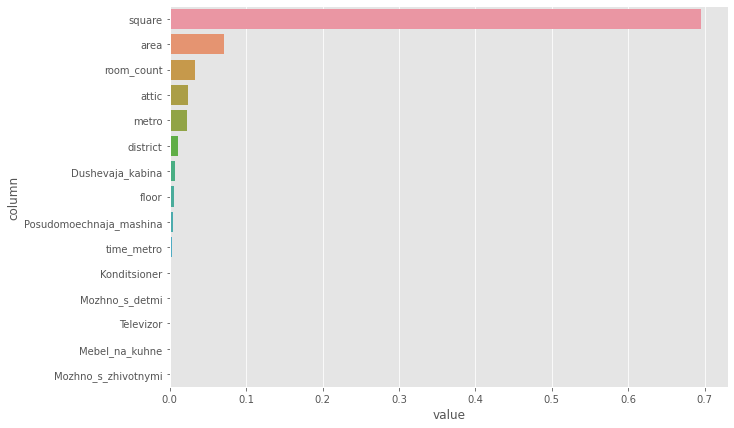

In [473]:
r = permutation_importance(lgb_grid,
                           X_test,
                           y_test,
                           n_repeats=4,
                           random_state=RAND)

feature_imp = pd.DataFrame()
feature_imp['column'] = X_test.columns
feature_imp['value'] = r['importances_mean']
feature_imp['2_std'] = 2*r['importances_std']

feature_imp.sort_values(by='value', inplace=True, ascending=False)

plt.figure(figsize=(10, 7))
sns.barplot(data=feature_imp[:15], x='value', y='column');

## LightGBM Cross-validation

In [436]:
score_oof, predictions_test = cross_validation(X_train,
                                               y_train,
                                               X_test,
                                               y_test,
                                               num_folds=N_FOLDS,
                                               early_stop=True,
                                               eval_metric='mae',
                                               early_stopping_rounds=100,
                                               clf=LGBMRegressor,
                                               params=lgb1)

Fold: 1 MAE SCORE 22995.121
---
Fold: 2 MAE SCORE 26523.236
---
Fold: 3 MAE SCORE 25120.427
---
Fold: 4 MAE SCORE 24902.310
---
Fold: 5 MAE SCORE 23274.443
---


In [437]:
test_pred = np.mean(predictions_test, axis=0)

print('MAE mean OOF: %.3f, std: %.3f' %
      (np.mean(score_oof), np.std(score_oof)))
print('MAE HOLDOUT: %.3f' % mean_absolute_error(y_test, test_pred))

MAE mean OOF: 24563.108, std: 1295.145
MAE HOLDOUT: 21444.598


In [438]:
metrics = metrics.append(
    get_metrics_regression(y_test=y_test,
                           y_pred=test_pred,
                           X_test=X_test,
                           name='LGBM_CV_Holdout'))

round(metrics.set_index('model'), 3)

,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
model,,,,,,,,
LGBM_Baseline,22702.340,4.903732e+09,70026.655,0.237,0.712,-2.237,16.781,22.243
LGBM_Tuning,21653.980,4.581074e+09,67683.634,0.235,0.731,-3.214,17.165,21.216
LGBM_CV_Holdout,21444.598,4.435506e+09,66599.591,0.231,0.739,-3.043,16.717,21.011


## CatBoost Baseline

In [86]:
cat_f = X_val.select_dtypes("category").columns.tolist()

clf2 = CatBoostRegressor(allow_writing_files=False,
                         random_state=RAND,
                         eval_metric="MAE",
                         cat_features=cat_f)
eval_set = [(X_val, y_val)]

clf2.fit(X_train_,
         y_train_,
         eval_set=eval_set,
         verbose=False,
         early_stopping_rounds=100)

In [70]:
check_overfitting(clf2, X_train_, y_train_, X_test, y_test,
                  mean_absolute_error)

mean_absolute_error train: 18357.162
mean_absolute_error test: 21845.731
delta = 16.0 %


In [439]:
y_pred = clf2.predict(X_test)

metrics = metrics.append(
    get_metrics_regression(y_test=y_test,
                           y_pred=y_pred,
                           X_test=X_test,
                           name='CatBoost_Baseline'))

round(metrics.set_index('model'), 3)

,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
model,,,,,,,,
LGBM_Baseline,22702.340,4.903732e+09,70026.655,0.237,0.712,-2.237,16.781,22.243
LGBM_Tuning,21653.980,4.581074e+09,67683.634,0.235,0.731,-3.214,17.165,21.216
LGBM_CV_Holdout,21444.598,4.435506e+09,66599.591,0.231,0.739,-3.043,16.717,21.011
CatBoost_Baseline,21845.731,2.752059e+09,52460.075,0.237,0.838,-5.687,18.388,21.404


## CatBoost Tuning

In [60]:
def objective_cat(trial, X, y, N_FOLDS, random_state, cat_feat):
    """Целевая функция для подбора learning rate для CatBoost"""
    
    params = {
        "n_estimators": trial.suggest_categorical("n_estimators", [1000]),
        "learning_rate": trial.suggest_float("learning_rate",
                                             0.01,
                                             0.3,
                                             log=True),
        "cat_features": cat_feat,
        "loss_function": "MAE",
        "use_best_model": True,
        "eval_metric": "MAE",
        "random_state": random_state
    }

    cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RAND)

    cv_predicts = np.empty(N_FOLDS)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        train_data = Pool(data=X_train, label=y_train, cat_features=cat_feat)
        eval_data = Pool(data=X_test, label=y_test, cat_features=cat_feat)

        model = CatBoostRegressor(**params)
        model.fit(train_data,
                  eval_set=eval_data,
                  early_stopping_rounds=100,
                  verbose=0)

        preds = model.predict(X_test)
        cv_predicts[idx] = mean_absolute_error(y_test, preds)

    return np.mean(cv_predicts)

In [61]:
study_cat = optuna.create_study(
    direction="minimize",
    pruner=optuna.pruners.SuccessiveHalvingPruner(),
    study_name="Cat")


def func(trial):
    """Подбор learning rate CatBoost"""
    
    return objective_cat(trial,
                         X_train,
                         y_train,
                         N_FOLDS=N_FOLDS,
                         random_state=RAND,
                         cat_feat=cat_f)


optuna.logging.set_verbosity(optuna.logging.WARNING)
study_cat.optimize(func, n_trials=300, show_progress_bar=True, n_jobs=-1)

  0%|          | 0/300 [00:00<?, ?it/s]

In [62]:
study_cat.best_params

{'n_estimators': 1000, 'learning_rate': 0.14991172120673607}

In [44]:
def objective_cat(trial, X, y, N_FOLDS, random_state, cat_feat):
    """Целевая функция для подбора всех гиперпараметров для CatBoost"""
    
    params = {
        "n_estimators":
        trial.suggest_categorical("n_estimators", [1000]),
        "learning_rate":
        trial.suggest_categorical("learning_rate", [0.14991172120673607]),
        "max_depth":
        trial.suggest_int("max_depth", 6, 10),
        "colsample_bylevel":
        trial.suggest_float("colsample_bylevel", 0.3, 0.8),
        "l2_leaf_reg":
        trial.suggest_uniform("l2_leaf_reg", 80, 1000),
        "random_strength":
        trial.suggest_int("random_strength", 1, 50),
        "bootstrap_type":
        trial.suggest_categorical("bootstrap_type",
                                  ["Bayesian", "Bernoulli", "MVS"]),
        "border_count":
        trial.suggest_categorical("border_count", [254]),
        "min_child_samples":
        trial.suggest_int("min_child_samples", 5, 50),
        "od_wait":
        trial.suggest_int("od_wait", 80, 300),
        "cat_features":
        cat_feat,
        "loss_function":
        trial.suggest_categorical("loss_function", ["MAE"]),
        "use_best_model":
        trial.suggest_categorical("use_best_model", [True]),
        "eval_metric":
        trial.suggest_categorical("eval_metric", ["MAE"]),
        "random_seed":
        random_state
    }
    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float(
            "bagging_temperature", 0, 10)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.7, 1)


    cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RAND)

    cv_predicts = np.empty(N_FOLDS)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        train_data = Pool(data=X_train, label=y_train, cat_features=cat_feat)
        eval_data = Pool(data=X_test, label=y_test, cat_features=cat_feat)

        model = CatBoostRegressor(**params)
        model.fit(train_data,
                  eval_set=eval_data,
                  early_stopping_rounds=100,
                  verbose=0)

        preds = model.predict(X_test)
        cv_predicts[idx] = mean_absolute_error(y_test, preds)

    return np.mean(cv_predicts)

In [45]:
study_cat = optuna.create_study(
    direction="minimize",
    pruner=optuna.pruners.SuccessiveHalvingPruner(),
    study_name="Cat",
)


def func(trial):
    """Подбор оптимальных гиперпараметров CatBoost"""
    
    return objective_cat(trial,
                         X_train,
                         y_train,
                         N_FOLDS=N_FOLDS,
                         random_state=RAND,
                         cat_feat=cat_f)


optuna.logging.set_verbosity(optuna.logging.WARNING)
study_cat.optimize(func, n_trials=100, show_progress_bar=True, n_jobs=-1)

  0%|          | 0/100 [00:00<?, ?it/s]

In [46]:
study_cat.best_params

{'n_estimators': 1000,
 'learning_rate': 0.14991172120673607,
 'max_depth': 7,
 'colsample_bylevel': 0.588290557290773,
 'l2_leaf_reg': 164.76268199948822,
 'random_strength': 11,
 'bootstrap_type': 'Bernoulli',
 'border_count': 254,
 'min_child_samples': 30,
 'od_wait': 229,
 'loss_function': 'MAE',
 'use_best_model': True,
 'eval_metric': 'MAE',
 'subsample': 0.8806530837369151}

In [93]:
catb = {
    'n_estimators': 1000,
    'learning_rate': 0.14991172120673607,
    'max_depth': 7,
    'colsample_bylevel': 0.588290557290773,
    'l2_leaf_reg': 164.76268199948822,
    'random_strength': 11,
    'bootstrap_type': 'Bernoulli',
    'border_count': 254,
    'min_child_samples': 30,
    'od_wait': 229,
    'loss_function': 'MAE',
    'use_best_model': True,
    'eval_metric': 'MAE',
    'subsample': 0.8806530837369151
}

In [88]:
cat_grid = CatBoostRegressor(**study_cat.best_params)
cat_grid.fit(X_train_,
             y_train_,
             cat_features=cat_f,
             eval_set=eval_set,
             verbose=False,
             early_stopping_rounds=100)

In [74]:
check_overfitting(cat_grid, X_train_, y_train_, X_test, y_test,
                  mean_absolute_error)

mean_absolute_error train: 18409.710
mean_absolute_error test: 21117.557
delta = 12.8 %


In [440]:
y_pred = cat_grid.predict(X_test)

metrics = metrics.append(
    get_metrics_regression(y_test=y_test,
                           y_pred=y_pred,
                           X_test=X_test,
                           name='CatBoost_Tuning'))

round(metrics.set_index('model'), 3)

,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
model,,,,,,,,
LGBM_Baseline,22702.340,4.903732e+09,70026.655,0.237266,0.712,-2.237,16.781,22.243
LGBM_Tuning,21653.980,4.581074e+09,67683.634,0.235498,0.731,-3.214,17.165,21.216
LGBM_CV_Holdout,21444.598,4.435506e+09,66599.591,0.230942,0.739,-3.043,16.717,21.011
CatBoost_Baseline,21845.731,2.752059e+09,52460.075,0.237001,0.838,-5.687,18.388,21.404
CatBoost_Tuning,21117.557,3.342223e+09,57811.959,None,0.804,-2.216,16.666,20.690


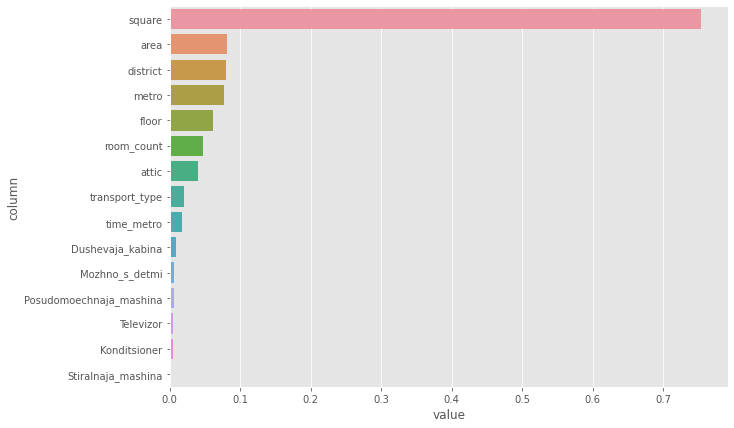

In [472]:
r = permutation_importance(cat_grid,
                           X_test,
                           y_test,
                           n_repeats=4,
                           random_state=RAND)

feature_imp = pd.DataFrame()
feature_imp['column'] = X_test.columns
feature_imp['value'] = r['importances_mean']
feature_imp['2_std'] = 2*r['importances_std']

feature_imp.sort_values(by='value', inplace=True, ascending=False)

plt.figure(figsize=(10, 7))
sns.barplot(data=feature_imp[:15], x='value', y='column');

## CatBoost Cross-validation

In [441]:
score_oof, predictions_test = cross_validation_cat(
    X_train,
    y_train,
    X_test,
    y_test,
    early_stop=True,
    cat_features=cat_f,
    early_stopping_rounds=100,
    num_folds=N_FOLDS,
    clf=CatBoostRegressor,
    params=catb)

Fold: 1 MAE SCORE 23324.979
---
Fold: 2 MAE SCORE 25352.648
---
Fold: 3 MAE SCORE 25711.046
---
Fold: 4 MAE SCORE 24560.102
---
Fold: 5 MAE SCORE 24250.761
---


In [442]:
test_pred = np.mean(predictions_test, axis=0)

print('MAE mean OOF: %.3f, std: %.3f' %
      (np.mean(score_oof), np.std(score_oof)))
print('MAE HOLDOUT: %.3f' % mean_absolute_error(y_test, test_pred))

MAE mean OOF: 24639.907, std: 841.686
MAE HOLDOUT: 20542.248


In [443]:
metrics = metrics.append(
    get_metrics_regression(y_test=y_test,
                           y_pred=test_pred,
                           X_test=X_test,
                           name='CatBoost_CV_Holdout'))

round(metrics.set_index('model'), 3)

,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
model,,,,,,,,
LGBM_Baseline,22702.340,4.903732e+09,70026.655,0.237266,0.712,-2.237,16.781,22.243
LGBM_Tuning,21653.980,4.581074e+09,67683.634,0.235498,0.731,-3.214,17.165,21.216
LGBM_CV_Holdout,21444.598,4.435506e+09,66599.591,0.230942,0.739,-3.043,16.717,21.011
CatBoost_Baseline,21845.731,2.752059e+09,52460.075,0.237001,0.838,-5.687,18.388,21.404
CatBoost_Tuning,21117.557,3.342223e+09,57811.959,None,0.804,-2.216,16.666,20.690
CatBoost_CV_Holdout,20542.248,3.302656e+09,57468.743,0.220384,0.806,-2.364,15.887,20.127


# Blending


## Blending baseline

### Blending modified

In [444]:
class BlendingRegressorModified(BaseEstimator, RegressorMixin):
    """
    Класс для блендинга, использующий все данные для обучения.
    ...
    Атрибуты
    --------
        models - базовые модели для стекинга
        ens_model - мета-модель
    Методы
    ------
    fit():
        Обучает ансамбль моделей.
    predict():
        Предоставляет прогнозы.
    """
    
    def __init__(self, models, ens_model):
        """
        models - базовые модели для стекинга
        ens_model - мета-модель
        """
        self.models = models
        self.ens_model = ens_model

    def fit(self,
            X: pd.DataFrame,
            y: pd.Series,
            test_size: float = 0.15,
            random_state: int = 10):
        """
        Обучение ансамбля моделей
        """
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=test_size, random_state=random_state)

        # список с новыми признаками на validation и train
        meta_X_train = []
        meta_X_val = []

        for model in self.models:
            # обучение на train датасете
            model.fit(X_train, y_train)
            # ответы на validation выборке
            yhat_val = model.predict(X_val)
            # преобразование в столбец
            yhat_val = yhat_val.reshape(len(yhat_val), 1)
            # запись в новый датасет
            meta_X_train.append(yhat_val)

            # обучение на validation датасете
            model.fit(X_val, y_val)
            yhat_train = model.predict(X_train)
            yhat_train = yhat_train.reshape(len(yhat_train), 1)
            meta_X_val.append(yhat_train)

        meta_X_train = np.hstack(meta_X_train)
        meta_X_val = np.hstack(meta_X_val)
        meta_X = np.vstack((meta_X_train, meta_X_val))

        self.ens_model.fit(meta_X, np.hstack((y_val, y_train)))
        return self

    def predict(self, X: pd.DataFrame) -> np.array:
        """
        получение прогнозов
        """
        meta_X = []

        for model in self.models:
            yhat = model.predict(X)
            yhat = yhat.reshape(len(yhat), 1)
            meta_X.append(yhat)
        meta_X = np.hstack(meta_X)
        return self.ens_model.predict(meta_X)

In [445]:
alg1 = LGBMRegressor(random_state=RAND, objective='mae')
alg2 = CatBoostRegressor(random_state=RAND,
                         eval_metric="MAE",
                         cat_features=cat_f)
models = [alg1, alg2]
meta_model = KNeighborsRegressor()

blendrm = BlendingRegressorModified(models, meta_model)
blendrm.fit(X=X_train, y=y_train, random_state=RAND)

Learning rate set to 0.063809
0:	learn: 78489.4674356	total: 22.6ms	remaining: 22.5s
1:	learn: 74591.7864524	total: 44.5ms	remaining: 22.2s
2:	learn: 70893.3292575	total: 67.9ms	remaining: 22.6s
3:	learn: 67380.8998101	total: 86.7ms	remaining: 21.6s
4:	learn: 64437.0947087	total: 106ms	remaining: 21.2s
5:	learn: 61566.3894382	total: 126ms	remaining: 20.8s
6:	learn: 58859.7877707	total: 145ms	remaining: 20.6s
7:	learn: 56512.9073464	total: 164ms	remaining: 20.4s
8:	learn: 54408.0407202	total: 184ms	remaining: 20.3s
9:	learn: 52377.8917708	total: 207ms	remaining: 20.5s
10:	learn: 50604.1418794	total: 228ms	remaining: 20.5s
11:	learn: 49112.0021672	total: 248ms	remaining: 20.4s
12:	learn: 47714.9182055	total: 267ms	remaining: 20.2s
13:	learn: 46552.4216326	total: 288ms	remaining: 20.3s
14:	learn: 45452.8862008	total: 307ms	remaining: 20.2s
15:	learn: 44285.8186073	total: 331ms	remaining: 20.4s
16:	learn: 43469.6105318	total: 352ms	remaining: 20.4s
17:	learn: 42619.0117334	total: 372ms	rem

152:	learn: 26521.8696395	total: 3.15s	remaining: 17.4s
153:	learn: 26482.4685480	total: 3.2s	remaining: 17.6s
154:	learn: 26482.4859931	total: 3.21s	remaining: 17.5s
155:	learn: 26454.9948677	total: 3.23s	remaining: 17.5s
156:	learn: 26441.1081587	total: 3.25s	remaining: 17.4s
157:	learn: 26441.1062046	total: 3.25s	remaining: 17.3s
158:	learn: 26397.4601640	total: 3.27s	remaining: 17.3s
159:	learn: 26367.8775610	total: 3.29s	remaining: 17.3s
160:	learn: 26356.8395508	total: 3.32s	remaining: 17.3s
161:	learn: 26331.1117962	total: 3.34s	remaining: 17.3s
162:	learn: 26317.8436700	total: 3.36s	remaining: 17.3s
163:	learn: 26296.0699929	total: 3.38s	remaining: 17.2s
164:	learn: 26274.3727292	total: 3.4s	remaining: 17.2s
165:	learn: 26252.9125279	total: 3.42s	remaining: 17.2s
166:	learn: 26245.0693322	total: 3.44s	remaining: 17.2s
167:	learn: 26229.3512480	total: 3.47s	remaining: 17.2s
168:	learn: 26225.5866623	total: 3.49s	remaining: 17.1s
169:	learn: 26190.0878461	total: 3.51s	remaining: 

303:	learn: 24037.4273503	total: 6.3s	remaining: 14.4s
304:	learn: 24028.1009279	total: 6.32s	remaining: 14.4s
305:	learn: 24012.4743950	total: 6.34s	remaining: 14.4s
306:	learn: 23994.8277506	total: 6.36s	remaining: 14.4s
307:	learn: 23983.9803009	total: 6.38s	remaining: 14.3s
308:	learn: 23956.4193924	total: 6.4s	remaining: 14.3s
309:	learn: 23946.8541056	total: 6.42s	remaining: 14.3s
310:	learn: 23936.7405337	total: 6.44s	remaining: 14.3s
311:	learn: 23931.5330675	total: 6.46s	remaining: 14.3s
312:	learn: 23921.1854546	total: 6.49s	remaining: 14.2s
313:	learn: 23896.8272752	total: 6.51s	remaining: 14.2s
314:	learn: 23878.7607678	total: 6.53s	remaining: 14.2s
315:	learn: 23869.8069370	total: 6.55s	remaining: 14.2s
316:	learn: 23845.1529970	total: 6.57s	remaining: 14.2s
317:	learn: 23831.4278016	total: 6.59s	remaining: 14.1s
318:	learn: 23825.3102927	total: 6.61s	remaining: 14.1s
319:	learn: 23801.7720014	total: 6.63s	remaining: 14.1s
320:	learn: 23797.6892102	total: 6.65s	remaining: 

452:	learn: 22470.1399196	total: 9.46s	remaining: 11.4s
453:	learn: 22467.7101923	total: 9.48s	remaining: 11.4s
454:	learn: 22463.2811960	total: 9.5s	remaining: 11.4s
455:	learn: 22454.2407318	total: 9.53s	remaining: 11.4s
456:	learn: 22444.4552740	total: 9.55s	remaining: 11.3s
457:	learn: 22440.5911039	total: 9.57s	remaining: 11.3s
458:	learn: 22425.5146949	total: 9.59s	remaining: 11.3s
459:	learn: 22420.4369600	total: 9.61s	remaining: 11.3s
460:	learn: 22418.3536082	total: 9.63s	remaining: 11.3s
461:	learn: 22414.2730014	total: 9.65s	remaining: 11.2s
462:	learn: 22409.4620582	total: 9.67s	remaining: 11.2s
463:	learn: 22405.7258644	total: 9.69s	remaining: 11.2s
464:	learn: 22395.2475766	total: 9.71s	remaining: 11.2s
465:	learn: 22394.2262294	total: 9.73s	remaining: 11.1s
466:	learn: 22385.2145663	total: 9.75s	remaining: 11.1s
467:	learn: 22379.2335427	total: 9.77s	remaining: 11.1s
468:	learn: 22367.1394172	total: 9.79s	remaining: 11.1s
469:	learn: 22353.2863002	total: 9.81s	remaining:

606:	learn: 21101.7278828	total: 12.6s	remaining: 8.18s
607:	learn: 21094.3371231	total: 12.7s	remaining: 8.16s
608:	learn: 21085.8523561	total: 12.7s	remaining: 8.14s
609:	learn: 21076.1452949	total: 12.7s	remaining: 8.12s
610:	learn: 21071.7335010	total: 12.7s	remaining: 8.1s
611:	learn: 21067.8519267	total: 12.7s	remaining: 8.08s
612:	learn: 21063.0605861	total: 12.8s	remaining: 8.06s
613:	learn: 21049.5960378	total: 12.8s	remaining: 8.04s
614:	learn: 21045.8043478	total: 12.8s	remaining: 8.02s
615:	learn: 21037.5073924	total: 12.8s	remaining: 8s
616:	learn: 21029.1848716	total: 12.8s	remaining: 7.97s
617:	learn: 21025.6952724	total: 12.9s	remaining: 7.95s
618:	learn: 21016.7066188	total: 12.9s	remaining: 7.93s
619:	learn: 21007.6446474	total: 12.9s	remaining: 7.91s
620:	learn: 21000.1144160	total: 12.9s	remaining: 7.89s
621:	learn: 20990.9873195	total: 12.9s	remaining: 7.87s
622:	learn: 20982.5557872	total: 13s	remaining: 7.85s
623:	learn: 20978.2078243	total: 13s	remaining: 7.83s


755:	learn: 19920.6345381	total: 15.8s	remaining: 5.09s
756:	learn: 19910.6810452	total: 15.8s	remaining: 5.07s
757:	learn: 19908.2493741	total: 15.8s	remaining: 5.05s
758:	learn: 19906.4814882	total: 15.8s	remaining: 5.03s
759:	learn: 19901.0770606	total: 15.9s	remaining: 5.01s
760:	learn: 19900.4100057	total: 15.9s	remaining: 4.99s
761:	learn: 19888.9925343	total: 15.9s	remaining: 4.96s
762:	learn: 19878.6733972	total: 15.9s	remaining: 4.94s
763:	learn: 19871.1000102	total: 15.9s	remaining: 4.92s
764:	learn: 19868.5979534	total: 16s	remaining: 4.9s
765:	learn: 19860.7929187	total: 16s	remaining: 4.88s
766:	learn: 19854.9409095	total: 16s	remaining: 4.86s
767:	learn: 19846.1967605	total: 16s	remaining: 4.84s
768:	learn: 19833.2224643	total: 16s	remaining: 4.82s
769:	learn: 19831.3513775	total: 16.1s	remaining: 4.8s
770:	learn: 19825.2513028	total: 16.1s	remaining: 4.78s
771:	learn: 19819.5026094	total: 16.1s	remaining: 4.75s
772:	learn: 19815.9298249	total: 16.1s	remaining: 4.73s
773:

903:	learn: 19042.2400499	total: 18.9s	remaining: 2.01s
904:	learn: 19031.8291574	total: 18.9s	remaining: 1.99s
905:	learn: 19027.7789184	total: 19s	remaining: 1.97s
906:	learn: 19020.4604426	total: 19s	remaining: 1.95s
907:	learn: 19011.4895347	total: 19s	remaining: 1.93s
908:	learn: 19010.4159983	total: 19s	remaining: 1.91s
909:	learn: 19009.6729525	total: 19.1s	remaining: 1.88s
910:	learn: 19007.4117244	total: 19.1s	remaining: 1.86s
911:	learn: 19003.4067361	total: 19.1s	remaining: 1.84s
912:	learn: 19000.0268415	total: 19.1s	remaining: 1.82s
913:	learn: 18987.9823440	total: 19.1s	remaining: 1.8s
914:	learn: 18986.6661387	total: 19.2s	remaining: 1.78s
915:	learn: 18984.7072676	total: 19.2s	remaining: 1.76s
916:	learn: 18974.5213852	total: 19.2s	remaining: 1.74s
917:	learn: 18972.1313118	total: 19.2s	remaining: 1.72s
918:	learn: 18966.8074991	total: 19.3s	remaining: 1.7s
919:	learn: 18962.8156466	total: 19.3s	remaining: 1.68s
920:	learn: 18960.9814544	total: 19.3s	remaining: 1.66s
92

54:	learn: 29441.0802379	total: 814ms	remaining: 14s
55:	learn: 29331.6715222	total: 829ms	remaining: 14s
56:	learn: 29159.6562494	total: 844ms	remaining: 14s
57:	learn: 29008.0054935	total: 859ms	remaining: 14s
58:	learn: 28924.5579215	total: 871ms	remaining: 13.9s
59:	learn: 28701.6747934	total: 886ms	remaining: 13.9s
60:	learn: 28534.5064001	total: 901ms	remaining: 13.9s
61:	learn: 28386.1164183	total: 916ms	remaining: 13.9s
62:	learn: 28195.5228281	total: 931ms	remaining: 13.8s
63:	learn: 28113.9412014	total: 948ms	remaining: 13.9s
64:	learn: 27956.9788065	total: 963ms	remaining: 13.9s
65:	learn: 27820.7986090	total: 978ms	remaining: 13.8s
66:	learn: 27690.0314758	total: 993ms	remaining: 13.8s
67:	learn: 27583.6073253	total: 1.01s	remaining: 13.8s
68:	learn: 27397.7231255	total: 1.02s	remaining: 13.8s
69:	learn: 27262.3957956	total: 1.04s	remaining: 13.8s
70:	learn: 27182.3855350	total: 1.05s	remaining: 13.8s
71:	learn: 27092.3469536	total: 1.07s	remaining: 13.8s
72:	learn: 27020.4

211:	learn: 22221.8917267	total: 3.23s	remaining: 12s
212:	learn: 22215.0822229	total: 3.25s	remaining: 12s
213:	learn: 22212.7349936	total: 3.26s	remaining: 12s
214:	learn: 22211.6909710	total: 3.27s	remaining: 11.9s
215:	learn: 22163.9549375	total: 3.28s	remaining: 11.9s
216:	learn: 22146.5107956	total: 3.3s	remaining: 11.9s
217:	learn: 22141.8245578	total: 3.31s	remaining: 11.9s
218:	learn: 22089.6795672	total: 3.33s	remaining: 11.9s
219:	learn: 22071.3351958	total: 3.34s	remaining: 11.8s
220:	learn: 22066.6658084	total: 3.35s	remaining: 11.8s
221:	learn: 22061.4682745	total: 3.37s	remaining: 11.8s
222:	learn: 22049.4334591	total: 3.38s	remaining: 11.8s
223:	learn: 22008.4345393	total: 3.4s	remaining: 11.8s
224:	learn: 21982.2786900	total: 3.41s	remaining: 11.8s
225:	learn: 21966.4233807	total: 3.43s	remaining: 11.8s
226:	learn: 21947.0931952	total: 3.45s	remaining: 11.7s
227:	learn: 21929.9960144	total: 3.46s	remaining: 11.7s
228:	learn: 21924.6199205	total: 3.48s	remaining: 11.7s


368:	learn: 19647.1786529	total: 5.64s	remaining: 9.64s
369:	learn: 19636.2858215	total: 5.65s	remaining: 9.63s
370:	learn: 19634.3140844	total: 5.67s	remaining: 9.61s
371:	learn: 19629.6199316	total: 5.68s	remaining: 9.6s
372:	learn: 19609.1675401	total: 5.7s	remaining: 9.58s
373:	learn: 19579.9918601	total: 5.71s	remaining: 9.56s
374:	learn: 19576.0739880	total: 5.73s	remaining: 9.55s
375:	learn: 19554.5382066	total: 5.74s	remaining: 9.53s
376:	learn: 19538.0132950	total: 5.76s	remaining: 9.51s
377:	learn: 19536.0130820	total: 5.77s	remaining: 9.5s
378:	learn: 19505.1111021	total: 5.79s	remaining: 9.48s
379:	learn: 19472.0205527	total: 5.8s	remaining: 9.46s
380:	learn: 19461.4221564	total: 5.82s	remaining: 9.45s
381:	learn: 19433.6687523	total: 5.83s	remaining: 9.43s
382:	learn: 19414.0941723	total: 5.85s	remaining: 9.42s
383:	learn: 19393.9593491	total: 5.86s	remaining: 9.4s
384:	learn: 19384.6068225	total: 5.88s	remaining: 9.39s
385:	learn: 19375.1203109	total: 5.89s	remaining: 9.3

516:	learn: 17424.0689999	total: 7.85s	remaining: 7.33s
517:	learn: 17412.0375554	total: 7.86s	remaining: 7.32s
518:	learn: 17394.3682734	total: 7.88s	remaining: 7.3s
519:	learn: 17383.1747331	total: 7.89s	remaining: 7.29s
520:	learn: 17366.6939709	total: 7.91s	remaining: 7.27s
521:	learn: 17357.1925021	total: 7.92s	remaining: 7.26s
522:	learn: 17351.3831325	total: 7.94s	remaining: 7.24s
523:	learn: 17338.8174204	total: 7.95s	remaining: 7.22s
524:	learn: 17323.3739482	total: 7.97s	remaining: 7.21s
525:	learn: 17311.5506407	total: 7.98s	remaining: 7.19s
526:	learn: 17309.1913474	total: 8s	remaining: 7.18s
527:	learn: 17293.2512685	total: 8.01s	remaining: 7.16s
528:	learn: 17282.1768925	total: 8.03s	remaining: 7.15s
529:	learn: 17253.5587245	total: 8.04s	remaining: 7.13s
530:	learn: 17252.5254313	total: 8.06s	remaining: 7.12s
531:	learn: 17234.7796645	total: 8.07s	remaining: 7.1s
532:	learn: 17224.4345632	total: 8.09s	remaining: 7.09s
533:	learn: 17217.5904091	total: 8.1s	remaining: 7.07

666:	learn: 16207.5258919	total: 10.1s	remaining: 5.03s
667:	learn: 16198.4676512	total: 10.1s	remaining: 5.01s
668:	learn: 16185.7082660	total: 10.1s	remaining: 5s
669:	learn: 16183.1470544	total: 10.1s	remaining: 4.98s
670:	learn: 16167.5940015	total: 10.1s	remaining: 4.96s
671:	learn: 16160.1796253	total: 10.1s	remaining: 4.95s
672:	learn: 16151.4172086	total: 10.2s	remaining: 4.93s
673:	learn: 16150.9634861	total: 10.2s	remaining: 4.92s
674:	learn: 16141.1308539	total: 10.2s	remaining: 4.9s
675:	learn: 16136.2573594	total: 10.2s	remaining: 4.89s
676:	learn: 16129.8369988	total: 10.2s	remaining: 4.87s
677:	learn: 16125.7734807	total: 10.2s	remaining: 4.86s
678:	learn: 16119.9108617	total: 10.2s	remaining: 4.84s
679:	learn: 16118.6265114	total: 10.3s	remaining: 4.83s
680:	learn: 16117.5346802	total: 10.3s	remaining: 4.81s
681:	learn: 16110.9893082	total: 10.3s	remaining: 4.8s
682:	learn: 16100.5370591	total: 10.3s	remaining: 4.78s
683:	learn: 16092.6993044	total: 10.3s	remaining: 4.7

825:	learn: 15101.9328565	total: 12.5s	remaining: 2.63s
826:	learn: 15092.8158058	total: 12.5s	remaining: 2.62s
827:	learn: 15083.4785110	total: 12.5s	remaining: 2.6s
828:	learn: 15079.1123675	total: 12.5s	remaining: 2.59s
829:	learn: 15071.6095130	total: 12.6s	remaining: 2.57s
830:	learn: 15064.9987850	total: 12.6s	remaining: 2.56s
831:	learn: 15053.3765688	total: 12.6s	remaining: 2.54s
832:	learn: 15037.7274039	total: 12.6s	remaining: 2.53s
833:	learn: 15033.4864525	total: 12.6s	remaining: 2.51s
834:	learn: 15030.3897918	total: 12.6s	remaining: 2.5s
835:	learn: 15024.4265131	total: 12.7s	remaining: 2.48s
836:	learn: 15015.6861734	total: 12.7s	remaining: 2.47s
837:	learn: 15006.7251653	total: 12.7s	remaining: 2.45s
838:	learn: 14994.9358808	total: 12.7s	remaining: 2.44s
839:	learn: 14994.7039671	total: 12.7s	remaining: 2.42s
840:	learn: 14986.8554927	total: 12.7s	remaining: 2.41s
841:	learn: 14985.9692357	total: 12.7s	remaining: 2.39s
842:	learn: 14979.5247773	total: 12.8s	remaining: 

972:	learn: 14120.4206689	total: 14.7s	remaining: 409ms
973:	learn: 14107.5092822	total: 14.8s	remaining: 394ms
974:	learn: 14101.5520739	total: 14.8s	remaining: 379ms
975:	learn: 14094.4226747	total: 14.8s	remaining: 364ms
976:	learn: 14093.8713276	total: 14.8s	remaining: 349ms
977:	learn: 14088.5212632	total: 14.8s	remaining: 333ms
978:	learn: 14086.3983931	total: 14.8s	remaining: 318ms
979:	learn: 14085.7439827	total: 14.9s	remaining: 303ms
980:	learn: 14081.9495175	total: 14.9s	remaining: 288ms
981:	learn: 14068.4711582	total: 14.9s	remaining: 273ms
982:	learn: 14062.8094895	total: 14.9s	remaining: 258ms
983:	learn: 14050.3853117	total: 14.9s	remaining: 242ms
984:	learn: 14045.4644750	total: 14.9s	remaining: 227ms
985:	learn: 14038.4746563	total: 14.9s	remaining: 212ms
986:	learn: 14037.8641971	total: 15s	remaining: 197ms
987:	learn: 14033.1239303	total: 15s	remaining: 182ms
988:	learn: 14025.7730661	total: 15s	remaining: 167ms
989:	learn: 14021.8022134	total: 15s	remaining: 152ms


BlendingRegressorModified(ens_model=KNeighborsRegressor(),
                          models=[LGBMRegressor(objective='mae',
                                                random_state=10),
                                  <catboost.core.CatBoostRegressor object at 0x000002ABA3210BE0>])

In [446]:
y_pred = blendrm.predict(X_test)

metrics = metrics.append(
    get_metrics_regression(y_test,
                           y_pred,
                           X_test,
                           name='BlendingRegressorModified'))

round(metrics.set_index('model'), 3)

,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
model,,,,,,,,
LGBM_Baseline,22702.340,4.903732e+09,70026.655,0.237266,0.712,-2.237,16.781,22.243
LGBM_Tuning,21653.980,4.581074e+09,67683.634,0.235498,0.731,-3.214,17.165,21.216
LGBM_CV_Holdout,21444.598,4.435506e+09,66599.591,0.230942,0.739,-3.043,16.717,21.011
CatBoost_Baseline,21845.731,2.752059e+09,52460.075,0.237001,0.838,-5.687,18.388,21.404
CatBoost_Tuning,21117.557,3.342223e+09,57811.959,None,0.804,-2.216,16.666,20.690
CatBoost_CV_Holdout,20542.248,3.302656e+09,57468.743,0.220384,0.806,-2.364,15.887,20.127
BlendingRegressorModified,27502.563,6.063685e+09,77869.667,0.276283,0.644,-7.701,21.634,26.946


In [447]:
check_overfitting(blendrm, X_train_, y_train_, X_test, y_test,
                  mean_absolute_error)

mean_absolute_error train: 25174.318
mean_absolute_error test: 27502.563
delta = 8.5 %


### Blending standart

In [448]:
class BlendingRegressorClassic(BaseEstimator, RegressorMixin):
    """
    Класс для блендинга, использующий часть данных для обучения.
    ...
    Атрибуты
    --------
        models - базовые модели для стекинга
        ens_model - мета-модель
    Методы
    ------
    fit():
        Обучает ансамбль моделей.
    predict():
        Предоставляет прогнозы.
    """
    def __init__(self, models, ens_model):
        """
        models - базовые модели для стекинга
        ens_model - мета-модель
        """
        self.models = models
        self.ens_model = ens_model

    def fit(self,
            X: pd.DataFrame,
            y: pd.Series,
            test_size: float = 0.15,
            random_state: int = 10):
        """
        Обучение ансамбля моделей на всех данных
        """
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=test_size, random_state=random_state)

        meta_X = list()

        for model in self.models:
            model.fit(X_train, y_train)
            yhat = model.predict(X_val)
            yhat = yhat.reshape(len(yhat), 1)
            meta_X.append(yhat)

        meta_X = np.hstack(meta_X)
        self.ens_model.fit(meta_X, y_val)
        return self

    def predict(self, X: pd.DataFrame) -> np.array:
        """
        получение прогнозов 
        """
        meta_X = list()
        
        for model in self.models:
            yhat = model.predict(X)
            yhat = yhat.reshape(len(yhat), 1)
            meta_X.append(yhat)
        meta_X = np.hstack(meta_X)
        return self.ens_model.predict(meta_X)

In [449]:
blendcl = BlendingRegressorClassic(models, meta_model)
blendcl.fit(X=X_train, y=y_train, random_state=RAND)

Learning rate set to 0.063809
0:	learn: 78489.4674356	total: 22.3ms	remaining: 22.3s
1:	learn: 74591.7864524	total: 46.3ms	remaining: 23.1s
2:	learn: 70893.3292575	total: 70.1ms	remaining: 23.3s
3:	learn: 67380.8998101	total: 90ms	remaining: 22.4s
4:	learn: 64437.0947087	total: 111ms	remaining: 22s
5:	learn: 61566.3894382	total: 131ms	remaining: 21.7s
6:	learn: 58859.7877707	total: 150ms	remaining: 21.3s
7:	learn: 56512.9073464	total: 170ms	remaining: 21.1s
8:	learn: 54408.0407202	total: 189ms	remaining: 20.8s
9:	learn: 52377.8917708	total: 211ms	remaining: 20.8s
10:	learn: 50604.1418794	total: 232ms	remaining: 20.9s
11:	learn: 49112.0021672	total: 252ms	remaining: 20.7s
12:	learn: 47714.9182055	total: 271ms	remaining: 20.5s
13:	learn: 46552.4216326	total: 291ms	remaining: 20.5s
14:	learn: 45452.8862008	total: 309ms	remaining: 20.3s
15:	learn: 44285.8186073	total: 329ms	remaining: 20.2s
16:	learn: 43469.6105318	total: 348ms	remaining: 20.1s
17:	learn: 42619.0117334	total: 367ms	remaini

156:	learn: 26441.1081587	total: 3.17s	remaining: 17s
157:	learn: 26441.1062046	total: 3.18s	remaining: 16.9s
158:	learn: 26397.4601640	total: 3.2s	remaining: 16.9s
159:	learn: 26367.8775610	total: 3.22s	remaining: 16.9s
160:	learn: 26356.8395508	total: 3.24s	remaining: 16.9s
161:	learn: 26331.1117962	total: 3.26s	remaining: 16.9s
162:	learn: 26317.8436700	total: 3.28s	remaining: 16.9s
163:	learn: 26296.0699929	total: 3.3s	remaining: 16.8s
164:	learn: 26274.3727292	total: 3.32s	remaining: 16.8s
165:	learn: 26252.9125279	total: 3.34s	remaining: 16.8s
166:	learn: 26245.0693322	total: 3.36s	remaining: 16.8s
167:	learn: 26229.3512480	total: 3.39s	remaining: 16.8s
168:	learn: 26225.5866623	total: 3.41s	remaining: 16.7s
169:	learn: 26190.0878461	total: 3.43s	remaining: 16.7s
170:	learn: 26162.7809712	total: 3.45s	remaining: 16.7s
171:	learn: 26162.8712178	total: 3.45s	remaining: 16.6s
172:	learn: 26139.2400174	total: 3.47s	remaining: 16.6s
173:	learn: 26125.7032218	total: 3.49s	remaining: 16

306:	learn: 23994.8277506	total: 6.38s	remaining: 14.4s
307:	learn: 23983.9803009	total: 6.4s	remaining: 14.4s
308:	learn: 23956.4193924	total: 6.42s	remaining: 14.4s
309:	learn: 23946.8541056	total: 6.45s	remaining: 14.4s
310:	learn: 23936.7405337	total: 6.47s	remaining: 14.3s
311:	learn: 23931.5330675	total: 6.5s	remaining: 14.3s
312:	learn: 23921.1854546	total: 6.52s	remaining: 14.3s
313:	learn: 23896.8272752	total: 6.54s	remaining: 14.3s
314:	learn: 23878.7607678	total: 6.56s	remaining: 14.3s
315:	learn: 23869.8069370	total: 6.58s	remaining: 14.3s
316:	learn: 23845.1529970	total: 6.61s	remaining: 14.2s
317:	learn: 23831.4278016	total: 6.62s	remaining: 14.2s
318:	learn: 23825.3102927	total: 6.64s	remaining: 14.2s
319:	learn: 23801.7720014	total: 6.66s	remaining: 14.2s
320:	learn: 23797.6892102	total: 6.68s	remaining: 14.1s
321:	learn: 23791.0780292	total: 6.7s	remaining: 14.1s
322:	learn: 23764.7005210	total: 6.72s	remaining: 14.1s
323:	learn: 23758.5234138	total: 6.74s	remaining: 1

462:	learn: 22409.4620582	total: 9.65s	remaining: 11.2s
463:	learn: 22405.7258644	total: 9.67s	remaining: 11.2s
464:	learn: 22395.2475766	total: 9.69s	remaining: 11.1s
465:	learn: 22394.2262294	total: 9.71s	remaining: 11.1s
466:	learn: 22385.2145663	total: 9.72s	remaining: 11.1s
467:	learn: 22379.2335427	total: 9.74s	remaining: 11.1s
468:	learn: 22367.1394172	total: 9.77s	remaining: 11.1s
469:	learn: 22353.2863002	total: 9.79s	remaining: 11s
470:	learn: 22338.4104990	total: 9.8s	remaining: 11s
471:	learn: 22317.8707944	total: 9.82s	remaining: 11s
472:	learn: 22296.7479232	total: 9.85s	remaining: 11s
473:	learn: 22283.5540020	total: 9.87s	remaining: 10.9s
474:	learn: 22283.1260263	total: 9.89s	remaining: 10.9s
475:	learn: 22275.2139755	total: 9.91s	remaining: 10.9s
476:	learn: 22260.2259448	total: 9.93s	remaining: 10.9s
477:	learn: 22252.4987465	total: 9.95s	remaining: 10.9s
478:	learn: 22249.0927758	total: 9.97s	remaining: 10.8s
479:	learn: 22234.6705760	total: 9.99s	remaining: 10.8s
4

614:	learn: 21045.8043478	total: 12.8s	remaining: 8.01s
615:	learn: 21037.5073924	total: 12.8s	remaining: 7.99s
616:	learn: 21029.1848716	total: 12.8s	remaining: 7.97s
617:	learn: 21025.6952724	total: 12.9s	remaining: 7.95s
618:	learn: 21016.7066188	total: 12.9s	remaining: 7.93s
619:	learn: 21007.6446474	total: 12.9s	remaining: 7.91s
620:	learn: 21000.1144160	total: 12.9s	remaining: 7.88s
621:	learn: 20990.9873195	total: 12.9s	remaining: 7.86s
622:	learn: 20982.5557872	total: 13s	remaining: 7.84s
623:	learn: 20978.2078243	total: 13s	remaining: 7.82s
624:	learn: 20966.8055370	total: 13s	remaining: 7.8s
625:	learn: 20965.3071008	total: 13s	remaining: 7.78s
626:	learn: 20949.8424938	total: 13s	remaining: 7.76s
627:	learn: 20945.8585900	total: 13.1s	remaining: 7.74s
628:	learn: 20928.8641719	total: 13.1s	remaining: 7.71s
629:	learn: 20923.9548322	total: 13.1s	remaining: 7.69s
630:	learn: 20923.1005944	total: 13.1s	remaining: 7.67s
631:	learn: 20904.3360540	total: 13.1s	remaining: 7.65s
632

763:	learn: 19871.1000102	total: 16s	remaining: 4.94s
764:	learn: 19868.5979534	total: 16s	remaining: 4.92s
765:	learn: 19860.7929187	total: 16s	remaining: 4.9s
766:	learn: 19854.9409095	total: 16.1s	remaining: 4.88s
767:	learn: 19846.1967605	total: 16.1s	remaining: 4.86s
768:	learn: 19833.2224643	total: 16.1s	remaining: 4.83s
769:	learn: 19831.3513775	total: 16.1s	remaining: 4.81s
770:	learn: 19825.2513028	total: 16.1s	remaining: 4.79s
771:	learn: 19819.5026094	total: 16.1s	remaining: 4.77s
772:	learn: 19815.9298249	total: 16.2s	remaining: 4.75s
773:	learn: 19812.3633183	total: 16.2s	remaining: 4.73s
774:	learn: 19808.0937134	total: 16.2s	remaining: 4.71s
775:	learn: 19801.9293472	total: 16.2s	remaining: 4.68s
776:	learn: 19795.3627389	total: 16.3s	remaining: 4.66s
777:	learn: 19788.0703975	total: 16.3s	remaining: 4.64s
778:	learn: 19785.2526312	total: 16.3s	remaining: 4.62s
779:	learn: 19770.8575896	total: 16.3s	remaining: 4.6s
780:	learn: 19766.4602448	total: 16.3s	remaining: 4.58s


915:	learn: 18984.7072676	total: 19.1s	remaining: 1.75s
916:	learn: 18974.5213852	total: 19.1s	remaining: 1.73s
917:	learn: 18972.1313118	total: 19.2s	remaining: 1.71s
918:	learn: 18966.8074991	total: 19.2s	remaining: 1.69s
919:	learn: 18962.8156466	total: 19.2s	remaining: 1.67s
920:	learn: 18960.9814544	total: 19.2s	remaining: 1.65s
921:	learn: 18959.4550331	total: 19.2s	remaining: 1.63s
922:	learn: 18956.2823993	total: 19.3s	remaining: 1.61s
923:	learn: 18954.7445725	total: 19.3s	remaining: 1.58s
924:	learn: 18949.0873234	total: 19.3s	remaining: 1.56s
925:	learn: 18942.3430973	total: 19.3s	remaining: 1.54s
926:	learn: 18939.2384124	total: 19.3s	remaining: 1.52s
927:	learn: 18936.8837245	total: 19.4s	remaining: 1.5s
928:	learn: 18924.6072577	total: 19.4s	remaining: 1.48s
929:	learn: 18919.1935224	total: 19.4s	remaining: 1.46s
930:	learn: 18918.4063641	total: 19.4s	remaining: 1.44s
931:	learn: 18912.4249926	total: 19.4s	remaining: 1.42s
932:	learn: 18912.6719440	total: 19.5s	remaining:

BlendingRegressorClassic(ens_model=KNeighborsRegressor(),
                         models=[LGBMRegressor(objective='mae',
                                               random_state=10),
                                 <catboost.core.CatBoostRegressor object at 0x000002ABA3210BE0>])

In [450]:
y_pred = blendcl.predict(X_test)

metrics = metrics.append(
    get_metrics_regression(y_test,
                           y_pred,
                           X_test,
                           name='BlendingRegressorClassic'))

round(metrics.set_index('model'), 3)

,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
model,,,,,,,,
LGBM_Baseline,22702.340,4.903732e+09,70026.655,0.237266,0.712,-2.237,16.781,22.243
LGBM_Tuning,21653.980,4.581074e+09,67683.634,0.235498,0.731,-3.214,17.165,21.216
LGBM_CV_Holdout,21444.598,4.435506e+09,66599.591,0.230942,0.739,-3.043,16.717,21.011
CatBoost_Baseline,21845.731,2.752059e+09,52460.075,0.237001,0.838,-5.687,18.388,21.404
CatBoost_Tuning,21117.557,3.342223e+09,57811.959,None,0.804,-2.216,16.666,20.690
CatBoost_CV_Holdout,20542.248,3.302656e+09,57468.743,0.220384,0.806,-2.364,15.887,20.127
BlendingRegressorModified,27502.563,6.063685e+09,77869.667,0.276283,0.644,-7.701,21.634,26.946
BlendingRegressorClassic,22977.367,3.112280e+09,55787.810,0.243631,0.817,-5.714,18.844,22.513


In [451]:
check_overfitting(blendcl, X_train_, y_train_, X_test, y_test,
                  mean_absolute_error)

mean_absolute_error train: 20881.186
mean_absolute_error test: 22977.367
delta = 9.1 %


## Blending Tuning

In [248]:
cat_b = {
    'n_estimators': 1000,
    'learning_rate': 0.14991172120673607,
    'max_depth': 7,
    'colsample_bylevel': 0.588290557290773,
    'l2_leaf_reg': 164.76268199948822,
    'random_strength': 11,
    'bootstrap_type': 'Bernoulli',
    'border_count': 254,
    'min_child_samples': 30,
    'od_wait': 229,
    'loss_function': 'MAE',
    'eval_metric': 'MAE',
    'subsample': 0.8806530837369151
}

In [452]:
alg1 = LGBMRegressor(random_state=RAND, objective='mae')
alg2 = CatBoostRegressor(random_state=RAND,
                         eval_metric="MAE",
                         cat_features=cat_f)
alg3 = LGBMRegressor(**lgb1)
alg4 = LGBMRegressor(**lgb2)
alg5 = LGBMRegressor(**lgb3)
alg6 = CatBoostRegressor(**cat_b, cat_features=cat_f)

models = [alg1, alg2, alg3, alg4, alg5, alg6]
meta_model = KNeighborsRegressor(n_neighbors=25, weights='distance')

blend = BlendingRegressorClassic(models, meta_model)
blend.fit(X=X_train, y=y_train, random_state=RAND)

Learning rate set to 0.063809
0:	learn: 78489.4674356	total: 36.5ms	remaining: 36.5s
1:	learn: 74591.7864524	total: 58.5ms	remaining: 29.2s
2:	learn: 70893.3292575	total: 79.5ms	remaining: 26.4s
3:	learn: 67380.8998101	total: 99.9ms	remaining: 24.9s
4:	learn: 64437.0947087	total: 119ms	remaining: 23.8s
5:	learn: 61566.3894382	total: 139ms	remaining: 23.1s
6:	learn: 58859.7877707	total: 159ms	remaining: 22.5s
7:	learn: 56512.9073464	total: 178ms	remaining: 22.1s
8:	learn: 54408.0407202	total: 199ms	remaining: 21.9s
9:	learn: 52377.8917708	total: 221ms	remaining: 21.8s
10:	learn: 50604.1418794	total: 242ms	remaining: 21.8s
11:	learn: 49112.0021672	total: 260ms	remaining: 21.4s
12:	learn: 47714.9182055	total: 279ms	remaining: 21.1s
13:	learn: 46552.4216326	total: 298ms	remaining: 21s
14:	learn: 45452.8862008	total: 317ms	remaining: 20.8s
15:	learn: 44285.8186073	total: 336ms	remaining: 20.6s
16:	learn: 43469.6105318	total: 356ms	remaining: 20.6s
17:	learn: 42619.0117334	total: 375ms	remai

159:	learn: 26367.8775610	total: 3.15s	remaining: 16.6s
160:	learn: 26356.8395508	total: 3.17s	remaining: 16.5s
161:	learn: 26331.1117962	total: 3.19s	remaining: 16.5s
162:	learn: 26317.8436700	total: 3.21s	remaining: 16.5s
163:	learn: 26296.0699929	total: 3.23s	remaining: 16.5s
164:	learn: 26274.3727292	total: 3.25s	remaining: 16.5s
165:	learn: 26252.9125279	total: 3.27s	remaining: 16.4s
166:	learn: 26245.0693322	total: 3.29s	remaining: 16.4s
167:	learn: 26229.3512480	total: 3.31s	remaining: 16.4s
168:	learn: 26225.5866623	total: 3.33s	remaining: 16.4s
169:	learn: 26190.0878461	total: 3.36s	remaining: 16.4s
170:	learn: 26162.7809712	total: 3.38s	remaining: 16.4s
171:	learn: 26162.8712178	total: 3.39s	remaining: 16.3s
172:	learn: 26139.2400174	total: 3.41s	remaining: 16.3s
173:	learn: 26125.7032218	total: 3.43s	remaining: 16.3s
174:	learn: 26115.7543606	total: 3.45s	remaining: 16.3s
175:	learn: 26105.1213148	total: 3.48s	remaining: 16.3s
176:	learn: 26072.9893206	total: 3.5s	remaining:

311:	learn: 23931.5330675	total: 6.3s	remaining: 13.9s
312:	learn: 23921.1854546	total: 6.32s	remaining: 13.9s
313:	learn: 23896.8272752	total: 6.34s	remaining: 13.8s
314:	learn: 23878.7607678	total: 6.36s	remaining: 13.8s
315:	learn: 23869.8069370	total: 6.38s	remaining: 13.8s
316:	learn: 23845.1529970	total: 6.4s	remaining: 13.8s
317:	learn: 23831.4278016	total: 6.42s	remaining: 13.8s
318:	learn: 23825.3102927	total: 6.43s	remaining: 13.7s
319:	learn: 23801.7720014	total: 6.45s	remaining: 13.7s
320:	learn: 23797.6892102	total: 6.47s	remaining: 13.7s
321:	learn: 23791.0780292	total: 6.5s	remaining: 13.7s
322:	learn: 23764.7005210	total: 6.52s	remaining: 13.7s
323:	learn: 23758.5234138	total: 6.54s	remaining: 13.6s
324:	learn: 23737.3482923	total: 6.56s	remaining: 13.6s
325:	learn: 23723.7722806	total: 6.58s	remaining: 13.6s
326:	learn: 23715.4878491	total: 6.6s	remaining: 13.6s
327:	learn: 23707.0648934	total: 6.62s	remaining: 13.6s
328:	learn: 23696.7310777	total: 6.64s	remaining: 13

462:	learn: 22409.4620582	total: 9.42s	remaining: 10.9s
463:	learn: 22405.7258644	total: 9.44s	remaining: 10.9s
464:	learn: 22395.2475766	total: 9.46s	remaining: 10.9s
465:	learn: 22394.2262294	total: 9.48s	remaining: 10.9s
466:	learn: 22385.2145663	total: 9.5s	remaining: 10.8s
467:	learn: 22379.2335427	total: 9.52s	remaining: 10.8s
468:	learn: 22367.1394172	total: 9.54s	remaining: 10.8s
469:	learn: 22353.2863002	total: 9.56s	remaining: 10.8s
470:	learn: 22338.4104990	total: 9.58s	remaining: 10.8s
471:	learn: 22317.8707944	total: 9.6s	remaining: 10.7s
472:	learn: 22296.7479232	total: 9.62s	remaining: 10.7s
473:	learn: 22283.5540020	total: 9.64s	remaining: 10.7s
474:	learn: 22283.1260263	total: 9.66s	remaining: 10.7s
475:	learn: 22275.2139755	total: 9.68s	remaining: 10.7s
476:	learn: 22260.2259448	total: 9.7s	remaining: 10.6s
477:	learn: 22252.4987465	total: 9.73s	remaining: 10.6s
478:	learn: 22249.0927758	total: 9.74s	remaining: 10.6s
479:	learn: 22234.6705760	total: 9.77s	remaining: 1

616:	learn: 21029.1848716	total: 12.6s	remaining: 7.79s
617:	learn: 21025.6952724	total: 12.6s	remaining: 7.77s
618:	learn: 21016.7066188	total: 12.6s	remaining: 7.75s
619:	learn: 21007.6446474	total: 12.6s	remaining: 7.73s
620:	learn: 21000.1144160	total: 12.6s	remaining: 7.71s
621:	learn: 20990.9873195	total: 12.7s	remaining: 7.69s
622:	learn: 20982.5557872	total: 12.7s	remaining: 7.67s
623:	learn: 20978.2078243	total: 12.7s	remaining: 7.65s
624:	learn: 20966.8055370	total: 12.7s	remaining: 7.63s
625:	learn: 20965.3071008	total: 12.7s	remaining: 7.61s
626:	learn: 20949.8424938	total: 12.8s	remaining: 7.59s
627:	learn: 20945.8585900	total: 12.8s	remaining: 7.57s
628:	learn: 20928.8641719	total: 12.8s	remaining: 7.55s
629:	learn: 20923.9548322	total: 12.8s	remaining: 7.53s
630:	learn: 20923.1005944	total: 12.8s	remaining: 7.51s
631:	learn: 20904.3360540	total: 12.9s	remaining: 7.49s
632:	learn: 20892.3952869	total: 12.9s	remaining: 7.47s
633:	learn: 20883.6809405	total: 12.9s	remaining

769:	learn: 19831.3513775	total: 15.7s	remaining: 4.7s
770:	learn: 19825.2513028	total: 15.8s	remaining: 4.68s
771:	learn: 19819.5026094	total: 15.8s	remaining: 4.66s
772:	learn: 19815.9298249	total: 15.8s	remaining: 4.64s
773:	learn: 19812.3633183	total: 15.8s	remaining: 4.62s
774:	learn: 19808.0937134	total: 15.8s	remaining: 4.6s
775:	learn: 19801.9293472	total: 15.9s	remaining: 4.58s
776:	learn: 19795.3627389	total: 15.9s	remaining: 4.56s
777:	learn: 19788.0703975	total: 15.9s	remaining: 4.54s
778:	learn: 19785.2526312	total: 15.9s	remaining: 4.52s
779:	learn: 19770.8575896	total: 15.9s	remaining: 4.5s
780:	learn: 19766.4602448	total: 16s	remaining: 4.48s
781:	learn: 19751.5116623	total: 16s	remaining: 4.46s
782:	learn: 19749.3217139	total: 16s	remaining: 4.44s
783:	learn: 19744.9366142	total: 16s	remaining: 4.42s
784:	learn: 19738.8603868	total: 16.1s	remaining: 4.4s
785:	learn: 19735.9273349	total: 16.1s	remaining: 4.38s
786:	learn: 19734.5302338	total: 16.1s	remaining: 4.36s
787:

920:	learn: 18960.9814544	total: 18.9s	remaining: 1.62s
921:	learn: 18959.4550331	total: 18.9s	remaining: 1.6s
922:	learn: 18956.2823993	total: 18.9s	remaining: 1.58s
923:	learn: 18954.7445725	total: 18.9s	remaining: 1.55s
924:	learn: 18949.0873234	total: 18.9s	remaining: 1.53s
925:	learn: 18942.3430973	total: 19s	remaining: 1.51s
926:	learn: 18939.2384124	total: 19s	remaining: 1.49s
927:	learn: 18936.8837245	total: 19s	remaining: 1.47s
928:	learn: 18924.6072577	total: 19s	remaining: 1.45s
929:	learn: 18919.1935224	total: 19s	remaining: 1.43s
930:	learn: 18918.4063641	total: 19.1s	remaining: 1.41s
931:	learn: 18912.4249926	total: 19.1s	remaining: 1.39s
932:	learn: 18912.6719440	total: 19.1s	remaining: 1.37s
933:	learn: 18902.1217994	total: 19.1s	remaining: 1.35s
934:	learn: 18899.8681998	total: 19.1s	remaining: 1.33s
935:	learn: 18889.8460277	total: 19.2s	remaining: 1.31s
936:	learn: 18888.9953575	total: 19.2s	remaining: 1.29s
937:	learn: 18881.0827202	total: 19.2s	remaining: 1.27s
938

72:	learn: 29573.8647288	total: 1.5s	remaining: 19.1s
73:	learn: 29509.4868294	total: 1.53s	remaining: 19.1s
74:	learn: 29467.7997638	total: 1.55s	remaining: 19.2s
75:	learn: 29442.1321949	total: 1.58s	remaining: 19.2s
76:	learn: 29380.8304304	total: 1.6s	remaining: 19.2s
77:	learn: 29295.5378395	total: 1.62s	remaining: 19.2s
78:	learn: 29292.5790574	total: 1.63s	remaining: 19s
79:	learn: 29267.3797823	total: 1.66s	remaining: 19.1s
80:	learn: 29084.3890969	total: 1.68s	remaining: 19.1s
81:	learn: 29040.0656387	total: 1.71s	remaining: 19.1s
82:	learn: 29004.3208694	total: 1.73s	remaining: 19.1s
83:	learn: 28795.9175944	total: 1.75s	remaining: 19.1s
84:	learn: 28631.8270264	total: 1.78s	remaining: 19.1s
85:	learn: 28591.8181752	total: 1.8s	remaining: 19.1s
86:	learn: 28522.6298178	total: 1.82s	remaining: 19.1s
87:	learn: 28391.5835248	total: 1.85s	remaining: 19.1s
88:	learn: 28388.0963758	total: 1.86s	remaining: 19.1s
89:	learn: 28251.9041774	total: 1.88s	remaining: 19s
90:	learn: 28120.

224:	learn: 23056.1723661	total: 5.11s	remaining: 17.6s
225:	learn: 23049.4812118	total: 5.13s	remaining: 17.6s
226:	learn: 22951.5881011	total: 5.16s	remaining: 17.6s
227:	learn: 22932.3166900	total: 5.18s	remaining: 17.5s
228:	learn: 22909.9542949	total: 5.2s	remaining: 17.5s
229:	learn: 22880.7129717	total: 5.22s	remaining: 17.5s
230:	learn: 22870.3305736	total: 5.25s	remaining: 17.5s
231:	learn: 22865.4359816	total: 5.27s	remaining: 17.5s
232:	learn: 22845.0000392	total: 5.29s	remaining: 17.4s
233:	learn: 22841.9750198	total: 5.32s	remaining: 17.4s
234:	learn: 22820.4296761	total: 5.35s	remaining: 17.4s
235:	learn: 22787.3725600	total: 5.37s	remaining: 17.4s
236:	learn: 22779.1063371	total: 5.4s	remaining: 17.4s
237:	learn: 22769.6937314	total: 5.42s	remaining: 17.4s
238:	learn: 22766.4404045	total: 5.45s	remaining: 17.3s
239:	learn: 22751.0132978	total: 5.47s	remaining: 17.3s
240:	learn: 22739.0670996	total: 5.49s	remaining: 17.3s
241:	learn: 22733.5866700	total: 5.52s	remaining: 

375:	learn: 20208.9094750	total: 8.74s	remaining: 14.5s
376:	learn: 20187.2133460	total: 8.77s	remaining: 14.5s
377:	learn: 20179.0537450	total: 8.79s	remaining: 14.5s
378:	learn: 20157.8292016	total: 8.81s	remaining: 14.4s
379:	learn: 20106.2048700	total: 8.84s	remaining: 14.4s
380:	learn: 20098.0246165	total: 8.87s	remaining: 14.4s
381:	learn: 20085.0823367	total: 8.89s	remaining: 14.4s
382:	learn: 20080.1731725	total: 8.92s	remaining: 14.4s
383:	learn: 20068.1181327	total: 8.95s	remaining: 14.3s
384:	learn: 20059.9025688	total: 8.97s	remaining: 14.3s
385:	learn: 20057.2317961	total: 9s	remaining: 14.3s
386:	learn: 20045.5554579	total: 9.02s	remaining: 14.3s
387:	learn: 20041.7727069	total: 9.05s	remaining: 14.3s
388:	learn: 20041.4503161	total: 9.07s	remaining: 14.3s
389:	learn: 20033.3524658	total: 9.1s	remaining: 14.2s
390:	learn: 20028.2920291	total: 9.12s	remaining: 14.2s
391:	learn: 20009.3127421	total: 9.15s	remaining: 14.2s
392:	learn: 19967.3499486	total: 9.17s	remaining: 14

531:	learn: 18584.4405116	total: 12.6s	remaining: 11.1s
532:	learn: 18562.3988872	total: 12.6s	remaining: 11.1s
533:	learn: 18558.0212763	total: 12.6s	remaining: 11s
534:	learn: 18548.3557527	total: 12.7s	remaining: 11s
535:	learn: 18546.2230067	total: 12.7s	remaining: 11s
536:	learn: 18543.6849083	total: 12.7s	remaining: 11s
537:	learn: 18537.4353354	total: 12.7s	remaining: 10.9s
538:	learn: 18537.1972542	total: 12.8s	remaining: 10.9s
539:	learn: 18518.2446770	total: 12.8s	remaining: 10.9s
540:	learn: 18491.0071087	total: 12.8s	remaining: 10.9s
541:	learn: 18486.7448895	total: 12.8s	remaining: 10.8s
542:	learn: 18485.8191822	total: 12.9s	remaining: 10.8s
543:	learn: 18453.0441055	total: 12.9s	remaining: 10.8s
544:	learn: 18449.6661770	total: 12.9s	remaining: 10.8s
545:	learn: 18445.3303729	total: 12.9s	remaining: 10.8s
546:	learn: 18433.5199420	total: 13s	remaining: 10.7s
547:	learn: 18429.9871596	total: 13s	remaining: 10.7s
548:	learn: 18428.8296217	total: 13s	remaining: 10.7s
549:	l

684:	learn: 17541.2708769	total: 16.4s	remaining: 7.55s
685:	learn: 17536.1119563	total: 16.4s	remaining: 7.53s
686:	learn: 17532.1373869	total: 16.5s	remaining: 7.5s
687:	learn: 17527.6565455	total: 16.5s	remaining: 7.48s
688:	learn: 17524.1243353	total: 16.5s	remaining: 7.46s
689:	learn: 17520.3430884	total: 16.6s	remaining: 7.43s
690:	learn: 17517.7172682	total: 16.6s	remaining: 7.41s
691:	learn: 17515.9557331	total: 16.6s	remaining: 7.39s
692:	learn: 17512.4473837	total: 16.6s	remaining: 7.36s
693:	learn: 17501.6927431	total: 16.6s	remaining: 7.34s
694:	learn: 17501.5256801	total: 16.7s	remaining: 7.32s
695:	learn: 17471.2513791	total: 16.7s	remaining: 7.29s
696:	learn: 17469.6290624	total: 16.7s	remaining: 7.27s
697:	learn: 17468.9015444	total: 16.7s	remaining: 7.24s
698:	learn: 17457.4159759	total: 16.8s	remaining: 7.22s
699:	learn: 17457.0631088	total: 16.8s	remaining: 7.19s
700:	learn: 17455.7805257	total: 16.8s	remaining: 7.17s
701:	learn: 17449.0573685	total: 16.8s	remaining:

836:	learn: 16777.5495274	total: 20.1s	remaining: 3.91s
837:	learn: 16773.7247328	total: 20.1s	remaining: 3.88s
838:	learn: 16771.6290241	total: 20.1s	remaining: 3.86s
839:	learn: 16771.3686870	total: 20.1s	remaining: 3.84s
840:	learn: 16761.3348088	total: 20.2s	remaining: 3.81s
841:	learn: 16756.8934102	total: 20.2s	remaining: 3.79s
842:	learn: 16755.1735139	total: 20.2s	remaining: 3.76s
843:	learn: 16749.5176432	total: 20.2s	remaining: 3.74s
844:	learn: 16739.6158352	total: 20.3s	remaining: 3.71s
845:	learn: 16739.5713014	total: 20.3s	remaining: 3.69s
846:	learn: 16736.4796206	total: 20.3s	remaining: 3.67s
847:	learn: 16731.3664423	total: 20.3s	remaining: 3.64s
848:	learn: 16729.1412924	total: 20.3s	remaining: 3.62s
849:	learn: 16728.9981459	total: 20.4s	remaining: 3.59s
850:	learn: 16720.2677696	total: 20.4s	remaining: 3.57s
851:	learn: 16719.2848629	total: 20.4s	remaining: 3.55s
852:	learn: 16717.3850874	total: 20.4s	remaining: 3.52s
853:	learn: 16715.3999429	total: 20.5s	remaining

992:	learn: 16236.3685885	total: 23.7s	remaining: 167ms
993:	learn: 16235.9138042	total: 23.7s	remaining: 143ms
994:	learn: 16235.5998428	total: 23.7s	remaining: 119ms
995:	learn: 16233.5432716	total: 23.8s	remaining: 95.5ms
996:	learn: 16228.8703862	total: 23.8s	remaining: 71.6ms
997:	learn: 16228.3860705	total: 23.8s	remaining: 47.7ms
998:	learn: 16225.1331596	total: 23.8s	remaining: 23.9ms
999:	learn: 16221.6451262	total: 23.9s	remaining: 0us


BlendingRegressorClassic(ens_model=KNeighborsRegressor(n_neighbors=25,
                                                       weights='distance'),
                         models=[LGBMRegressor(objective='mae',
                                               random_state=10),
                                 LGBMRegressor(colsample_bytree=0.5344651242816658,
                                               learning_rate=0.06652789917177983,
                                               max_depth=10, metric='mae',
                                               min_child_samples=13,
                                               min_split_gain...
                                 LGBMRegressor(colsample_bytree=0.9578330521724169,
                                               learning_rate=0.06652789917177983,
                                               max_depth=8, metric='mae',
                                               min_child_samples=14,
                                        

In [453]:
y_pred = blend.predict(X_test)

metrics = metrics.append(
    get_metrics_regression(y_test,
                           y_pred,
                           X_test,
                           name='BlendingRegressorTuned'))

round(metrics.set_index('model'), 3)

,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
model,,,,,,,,
LGBM_Baseline,22702.340,4.903732e+09,70026.655,0.237266,0.712,-2.237,16.781,22.243
LGBM_Tuning,21653.980,4.581074e+09,67683.634,0.235498,0.731,-3.214,17.165,21.216
LGBM_CV_Holdout,21444.598,4.435506e+09,66599.591,0.230942,0.739,-3.043,16.717,21.011
CatBoost_Baseline,21845.731,2.752059e+09,52460.075,0.237001,0.838,-5.687,18.388,21.404
CatBoost_Tuning,21117.557,3.342223e+09,57811.959,None,0.804,-2.216,16.666,20.690
CatBoost_CV_Holdout,20542.248,3.302656e+09,57468.743,0.220384,0.806,-2.364,15.887,20.127
BlendingRegressorModified,27502.563,6.063685e+09,77869.667,0.276283,0.644,-7.701,21.634,26.946
BlendingRegressorClassic,22977.367,3.112280e+09,55787.810,0.243631,0.817,-5.714,18.844,22.513
BlendingRegressorTuned,20823.443,3.309022e+09,57524.101,0.224251,0.806,-5.216,16.851,20.402


In [454]:
check_overfitting(blend, X_train_, y_train_, X_test, y_test,
                  mean_absolute_error)

mean_absolute_error train: 19285.427
mean_absolute_error test: 20823.443
delta = 7.4 %


# Stacking

In [457]:
estimators = [('al1', alg1), ('al2', alg2), ('al3', alg3), ('al4', alg4),
              ('al5', alg5), ('al6', alg6)]

stf_cv = KFold(n_splits=5)
meta = StackingRegressor(estimators=estimators,
                         cv=stf_cv,
                         final_estimator=KNeighborsRegressor(
                             n_neighbors=29, weights='distance'))

In [458]:
meta.fit(X_train, y_train)

Learning rate set to 0.065469
0:	learn: 77849.6101014	total: 24.3ms	remaining: 24.3s
1:	learn: 73895.7158275	total: 50.1ms	remaining: 25s
2:	learn: 70131.4488601	total: 72.5ms	remaining: 24.1s
3:	learn: 66950.7469508	total: 93.6ms	remaining: 23.3s
4:	learn: 63779.2606569	total: 116ms	remaining: 23s
5:	learn: 61028.2243507	total: 137ms	remaining: 22.7s
6:	learn: 58401.5865656	total: 159ms	remaining: 22.5s
7:	learn: 56001.9221640	total: 179ms	remaining: 22.2s
8:	learn: 54142.6373970	total: 203ms	remaining: 22.3s
9:	learn: 52228.2365655	total: 224ms	remaining: 22.2s
10:	learn: 50334.9651124	total: 246ms	remaining: 22.1s
11:	learn: 48680.5594266	total: 272ms	remaining: 22.4s
12:	learn: 47179.0874620	total: 292ms	remaining: 22.2s
13:	learn: 46022.5304596	total: 312ms	remaining: 22s
14:	learn: 44911.4582350	total: 333ms	remaining: 21.8s
15:	learn: 43857.8544661	total: 353ms	remaining: 21.7s
16:	learn: 42708.1291076	total: 375ms	remaining: 21.7s
17:	learn: 41885.6249080	total: 395ms	remaining

154:	learn: 25560.1344662	total: 3.36s	remaining: 18.3s
155:	learn: 25534.0981346	total: 3.38s	remaining: 18.3s
156:	learn: 25530.8785413	total: 3.41s	remaining: 18.3s
157:	learn: 25502.0898001	total: 3.43s	remaining: 18.3s
158:	learn: 25486.7920851	total: 3.45s	remaining: 18.3s
159:	learn: 25470.2702547	total: 3.47s	remaining: 18.2s
160:	learn: 25448.2531386	total: 3.49s	remaining: 18.2s
161:	learn: 25447.9466574	total: 3.5s	remaining: 18.1s
162:	learn: 25412.9805807	total: 3.52s	remaining: 18.1s
163:	learn: 25400.2084234	total: 3.54s	remaining: 18.1s
164:	learn: 25390.2336108	total: 3.56s	remaining: 18s
165:	learn: 25374.9502700	total: 3.59s	remaining: 18s
166:	learn: 25335.2200831	total: 3.61s	remaining: 18s
167:	learn: 25300.3666397	total: 3.63s	remaining: 18s
168:	learn: 25282.9352060	total: 3.65s	remaining: 17.9s
169:	learn: 25267.3524531	total: 3.67s	remaining: 17.9s
170:	learn: 25245.8357362	total: 3.69s	remaining: 17.9s
171:	learn: 25231.9827808	total: 3.71s	remaining: 17.9s
1

304:	learn: 23203.6998367	total: 6.57s	remaining: 15s
305:	learn: 23185.9108539	total: 6.59s	remaining: 15s
306:	learn: 23176.1418447	total: 6.62s	remaining: 14.9s
307:	learn: 23175.9181533	total: 6.63s	remaining: 14.9s
308:	learn: 23167.1207930	total: 6.66s	remaining: 14.9s
309:	learn: 23154.3865863	total: 6.68s	remaining: 14.9s
310:	learn: 23148.1790805	total: 6.7s	remaining: 14.8s
311:	learn: 23130.9007572	total: 6.72s	remaining: 14.8s
312:	learn: 23110.3399986	total: 6.74s	remaining: 14.8s
313:	learn: 23105.8302700	total: 6.76s	remaining: 14.8s
314:	learn: 23096.3061834	total: 6.78s	remaining: 14.8s
315:	learn: 23082.7725055	total: 6.8s	remaining: 14.7s
316:	learn: 23069.4788303	total: 6.83s	remaining: 14.7s
317:	learn: 23060.0469540	total: 6.85s	remaining: 14.7s
318:	learn: 23052.3950226	total: 6.87s	remaining: 14.7s
319:	learn: 23045.3544745	total: 6.89s	remaining: 14.6s
320:	learn: 23036.1262244	total: 6.92s	remaining: 14.6s
321:	learn: 23023.9656753	total: 6.93s	remaining: 14.6

460:	learn: 21456.7797383	total: 9.97s	remaining: 11.7s
461:	learn: 21428.9886432	total: 9.99s	remaining: 11.6s
462:	learn: 21421.8966091	total: 10s	remaining: 11.6s
463:	learn: 21412.6984252	total: 10s	remaining: 11.6s
464:	learn: 21398.7810692	total: 10.1s	remaining: 11.6s
465:	learn: 21394.8509724	total: 10.1s	remaining: 11.5s
466:	learn: 21382.9674497	total: 10.1s	remaining: 11.5s
467:	learn: 21378.2890839	total: 10.1s	remaining: 11.5s
468:	learn: 21362.9424884	total: 10.1s	remaining: 11.5s
469:	learn: 21352.5793247	total: 10.2s	remaining: 11.5s
470:	learn: 21335.4519728	total: 10.2s	remaining: 11.4s
471:	learn: 21328.1520117	total: 10.2s	remaining: 11.4s
472:	learn: 21325.5485715	total: 10.2s	remaining: 11.4s
473:	learn: 21306.5095367	total: 10.3s	remaining: 11.4s
474:	learn: 21295.5954643	total: 10.3s	remaining: 11.4s
475:	learn: 21276.6619071	total: 10.3s	remaining: 11.3s
476:	learn: 21261.3450902	total: 10.3s	remaining: 11.3s
477:	learn: 21242.6847476	total: 10.3s	remaining: 11

609:	learn: 20196.6992048	total: 13.1s	remaining: 8.36s
610:	learn: 20192.8484747	total: 13.1s	remaining: 8.34s
611:	learn: 20192.0489871	total: 13.1s	remaining: 8.32s
612:	learn: 20186.4979326	total: 13.1s	remaining: 8.29s
613:	learn: 20180.6411135	total: 13.2s	remaining: 8.27s
614:	learn: 20176.0587022	total: 13.2s	remaining: 8.25s
615:	learn: 20175.2037993	total: 13.2s	remaining: 8.23s
616:	learn: 20171.7375095	total: 13.2s	remaining: 8.21s
617:	learn: 20168.3531197	total: 13.2s	remaining: 8.19s
618:	learn: 20163.7883823	total: 13.3s	remaining: 8.16s
619:	learn: 20160.2732576	total: 13.3s	remaining: 8.14s
620:	learn: 20159.5029645	total: 13.3s	remaining: 8.12s
621:	learn: 20147.5894432	total: 13.3s	remaining: 8.1s
622:	learn: 20140.5681912	total: 13.3s	remaining: 8.07s
623:	learn: 20132.9080504	total: 13.4s	remaining: 8.05s
624:	learn: 20127.5110400	total: 13.4s	remaining: 8.03s
625:	learn: 20118.6468473	total: 13.4s	remaining: 8.01s
626:	learn: 20116.4141772	total: 13.4s	remaining:

757:	learn: 19370.4168852	total: 16.3s	remaining: 5.19s
758:	learn: 19365.5437512	total: 16.3s	remaining: 5.17s
759:	learn: 19362.6355822	total: 16.3s	remaining: 5.15s
760:	learn: 19355.3491612	total: 16.3s	remaining: 5.13s
761:	learn: 19350.2834817	total: 16.4s	remaining: 5.11s
762:	learn: 19346.8525445	total: 16.4s	remaining: 5.09s
763:	learn: 19343.1419124	total: 16.4s	remaining: 5.07s
764:	learn: 19342.5298059	total: 16.4s	remaining: 5.04s
765:	learn: 19331.0615815	total: 16.4s	remaining: 5.02s
766:	learn: 19329.0005787	total: 16.5s	remaining: 5s
767:	learn: 19320.4291884	total: 16.5s	remaining: 4.98s
768:	learn: 19315.2211105	total: 16.5s	remaining: 4.96s
769:	learn: 19313.0860982	total: 16.5s	remaining: 4.94s
770:	learn: 19308.8026031	total: 16.6s	remaining: 4.92s
771:	learn: 19304.2701171	total: 16.6s	remaining: 4.89s
772:	learn: 19302.7904950	total: 16.6s	remaining: 4.87s
773:	learn: 19299.7770635	total: 16.6s	remaining: 4.85s
774:	learn: 19297.8677553	total: 16.6s	remaining: 4

906:	learn: 18692.7364568	total: 19.5s	remaining: 2s
907:	learn: 18691.9197181	total: 19.5s	remaining: 1.97s
908:	learn: 18689.9653504	total: 19.5s	remaining: 1.95s
909:	learn: 18687.2855897	total: 19.5s	remaining: 1.93s
910:	learn: 18685.5855094	total: 19.5s	remaining: 1.91s
911:	learn: 18677.8208788	total: 19.6s	remaining: 1.89s
912:	learn: 18673.2212904	total: 19.6s	remaining: 1.87s
913:	learn: 18662.9596181	total: 19.6s	remaining: 1.84s
914:	learn: 18654.5533500	total: 19.6s	remaining: 1.82s
915:	learn: 18653.0156341	total: 19.7s	remaining: 1.8s
916:	learn: 18649.3035072	total: 19.7s	remaining: 1.78s
917:	learn: 18645.4238708	total: 19.7s	remaining: 1.76s
918:	learn: 18642.7269048	total: 19.7s	remaining: 1.74s
919:	learn: 18640.9966883	total: 19.7s	remaining: 1.72s
920:	learn: 18636.6531321	total: 19.8s	remaining: 1.7s
921:	learn: 18635.3907238	total: 19.8s	remaining: 1.67s
922:	learn: 18631.7526036	total: 19.8s	remaining: 1.65s
923:	learn: 18623.7066503	total: 19.8s	remaining: 1.6

59:	learn: 29699.5242431	total: 1.31s	remaining: 20.5s
60:	learn: 29502.9524424	total: 1.33s	remaining: 20.5s
61:	learn: 29431.2692447	total: 1.35s	remaining: 20.5s
62:	learn: 29412.4472613	total: 1.38s	remaining: 20.5s
63:	learn: 29377.0380088	total: 1.4s	remaining: 20.5s
64:	learn: 29276.1272225	total: 1.42s	remaining: 20.5s
65:	learn: 29191.6890315	total: 1.45s	remaining: 20.5s
66:	learn: 29191.6890165	total: 1.45s	remaining: 20.2s
67:	learn: 29181.1157984	total: 1.48s	remaining: 20.2s
68:	learn: 29180.4007515	total: 1.49s	remaining: 20.1s
69:	learn: 29132.8526340	total: 1.51s	remaining: 20.1s
70:	learn: 29053.8731294	total: 1.54s	remaining: 20.2s
71:	learn: 29031.4855972	total: 1.57s	remaining: 20.2s
72:	learn: 29019.3038992	total: 1.6s	remaining: 20.3s
73:	learn: 28969.0911628	total: 1.63s	remaining: 20.4s
74:	learn: 28817.0911479	total: 1.66s	remaining: 20.4s
75:	learn: 28783.7902471	total: 1.68s	remaining: 20.5s
76:	learn: 28702.0574037	total: 1.71s	remaining: 20.5s
77:	learn: 2

213:	learn: 23250.9322417	total: 5.2s	remaining: 19.1s
214:	learn: 23234.1895527	total: 5.23s	remaining: 19.1s
215:	learn: 23231.6977298	total: 5.25s	remaining: 19.1s
216:	learn: 23200.7518166	total: 5.28s	remaining: 19s
217:	learn: 23176.4360158	total: 5.3s	remaining: 19s
218:	learn: 23167.4107389	total: 5.32s	remaining: 19s
219:	learn: 23162.6116857	total: 5.35s	remaining: 19s
220:	learn: 23158.2406260	total: 5.37s	remaining: 18.9s
221:	learn: 23128.5068733	total: 5.4s	remaining: 18.9s
222:	learn: 23091.4831025	total: 5.43s	remaining: 18.9s
223:	learn: 23068.8053194	total: 5.45s	remaining: 18.9s
224:	learn: 23050.4502900	total: 5.47s	remaining: 18.9s
225:	learn: 23030.3312962	total: 5.5s	remaining: 18.8s
226:	learn: 23011.3883948	total: 5.52s	remaining: 18.8s
227:	learn: 23009.3334847	total: 5.55s	remaining: 18.8s
228:	learn: 23005.4139853	total: 5.57s	remaining: 18.8s
229:	learn: 23001.4116127	total: 5.6s	remaining: 18.7s
230:	learn: 22996.1705152	total: 5.62s	remaining: 18.7s
231:	

367:	learn: 20501.4086769	total: 9.1s	remaining: 15.6s
368:	learn: 20497.2157102	total: 9.13s	remaining: 15.6s
369:	learn: 20463.2029937	total: 9.15s	remaining: 15.6s
370:	learn: 20441.1164982	total: 9.18s	remaining: 15.6s
371:	learn: 20421.6512348	total: 9.2s	remaining: 15.5s
372:	learn: 20407.4579898	total: 9.23s	remaining: 15.5s
373:	learn: 20397.7566848	total: 9.25s	remaining: 15.5s
374:	learn: 20368.1994088	total: 9.28s	remaining: 15.5s
375:	learn: 20367.8911038	total: 9.3s	remaining: 15.4s
376:	learn: 20355.0837012	total: 9.33s	remaining: 15.4s
377:	learn: 20305.4697481	total: 9.36s	remaining: 15.4s
378:	learn: 20298.0918095	total: 9.38s	remaining: 15.4s
379:	learn: 20297.4279708	total: 9.4s	remaining: 15.3s
380:	learn: 20275.1855230	total: 9.43s	remaining: 15.3s
381:	learn: 20243.9727344	total: 9.46s	remaining: 15.3s
382:	learn: 20237.9609659	total: 9.48s	remaining: 15.3s
383:	learn: 20226.3751171	total: 9.51s	remaining: 15.2s
384:	learn: 20222.4215360	total: 9.53s	remaining: 15

523:	learn: 18744.9712795	total: 13.1s	remaining: 11.9s
524:	learn: 18738.8593686	total: 13.1s	remaining: 11.9s
525:	learn: 18734.8547846	total: 13.1s	remaining: 11.8s
526:	learn: 18734.0303248	total: 13.2s	remaining: 11.8s
527:	learn: 18733.8669567	total: 13.2s	remaining: 11.8s
528:	learn: 18712.7632755	total: 13.2s	remaining: 11.8s
529:	learn: 18705.3886804	total: 13.2s	remaining: 11.7s
530:	learn: 18705.0862054	total: 13.3s	remaining: 11.7s
531:	learn: 18697.4720099	total: 13.3s	remaining: 11.7s
532:	learn: 18681.1719665	total: 13.3s	remaining: 11.7s
533:	learn: 18677.3462671	total: 13.3s	remaining: 11.6s
534:	learn: 18676.4196021	total: 13.4s	remaining: 11.6s
535:	learn: 18664.4938934	total: 13.4s	remaining: 11.6s
536:	learn: 18661.3802976	total: 13.4s	remaining: 11.6s
537:	learn: 18653.3281042	total: 13.4s	remaining: 11.5s
538:	learn: 18649.9844462	total: 13.5s	remaining: 11.5s
539:	learn: 18645.0433584	total: 13.5s	remaining: 11.5s
540:	learn: 18640.3764361	total: 13.5s	remaining

675:	learn: 17865.6861092	total: 16.8s	remaining: 8.06s
676:	learn: 17864.2750420	total: 16.9s	remaining: 8.04s
677:	learn: 17856.4473874	total: 16.9s	remaining: 8.02s
678:	learn: 17846.5795065	total: 16.9s	remaining: 7.99s
679:	learn: 17843.6046192	total: 16.9s	remaining: 7.97s
680:	learn: 17841.2031688	total: 17s	remaining: 7.95s
681:	learn: 17837.3954550	total: 17s	remaining: 7.92s
682:	learn: 17832.1601392	total: 17s	remaining: 7.9s
683:	learn: 17827.5387322	total: 17.1s	remaining: 7.88s
684:	learn: 17825.2794479	total: 17.1s	remaining: 7.85s
685:	learn: 17791.6033956	total: 17.1s	remaining: 7.83s
686:	learn: 17790.4567385	total: 17.1s	remaining: 7.81s
687:	learn: 17782.6313098	total: 17.2s	remaining: 7.79s
688:	learn: 17772.2366701	total: 17.2s	remaining: 7.76s
689:	learn: 17770.5477882	total: 17.2s	remaining: 7.74s
690:	learn: 17766.7913634	total: 17.2s	remaining: 7.71s
691:	learn: 17763.5938148	total: 17.3s	remaining: 7.69s
692:	learn: 17761.2810779	total: 17.3s	remaining: 7.66s

824:	learn: 17130.5201173	total: 20.8s	remaining: 4.4s
825:	learn: 17115.3680879	total: 20.8s	remaining: 4.38s
826:	learn: 17113.9062249	total: 20.8s	remaining: 4.35s
827:	learn: 17112.2380694	total: 20.8s	remaining: 4.33s
828:	learn: 17106.8907520	total: 20.9s	remaining: 4.3s
829:	learn: 17106.8066219	total: 20.9s	remaining: 4.28s
830:	learn: 17106.3217732	total: 20.9s	remaining: 4.25s
831:	learn: 17094.1876191	total: 20.9s	remaining: 4.23s
832:	learn: 17089.0222717	total: 21s	remaining: 4.2s
833:	learn: 17080.6913767	total: 21s	remaining: 4.17s
834:	learn: 17075.7787933	total: 21s	remaining: 4.15s
835:	learn: 17072.2833491	total: 21s	remaining: 4.13s
836:	learn: 17067.6950677	total: 21.1s	remaining: 4.1s
837:	learn: 17066.8644336	total: 21.1s	remaining: 4.08s
838:	learn: 17066.8152908	total: 21.1s	remaining: 4.05s
839:	learn: 17063.2065326	total: 21.1s	remaining: 4.03s
840:	learn: 17057.0347884	total: 21.2s	remaining: 4s
841:	learn: 17055.9937981	total: 21.2s	remaining: 3.98s
842:	le

975:	learn: 16579.2974608	total: 24.6s	remaining: 604ms
976:	learn: 16579.1111438	total: 24.6s	remaining: 579ms
977:	learn: 16577.0373912	total: 24.6s	remaining: 554ms
978:	learn: 16569.1577536	total: 24.6s	remaining: 528ms
979:	learn: 16565.9839150	total: 24.7s	remaining: 503ms
980:	learn: 16563.8878421	total: 24.7s	remaining: 478ms
981:	learn: 16562.5552777	total: 24.7s	remaining: 453ms
982:	learn: 16559.6590651	total: 24.7s	remaining: 428ms
983:	learn: 16558.4787614	total: 24.8s	remaining: 403ms
984:	learn: 16556.9396040	total: 24.8s	remaining: 378ms
985:	learn: 16547.0905533	total: 24.8s	remaining: 352ms
986:	learn: 16544.0757005	total: 24.8s	remaining: 327ms
987:	learn: 16536.8401464	total: 24.9s	remaining: 302ms
988:	learn: 16534.3186187	total: 24.9s	remaining: 277ms
989:	learn: 16529.5722426	total: 24.9s	remaining: 252ms
990:	learn: 16527.4438834	total: 25s	remaining: 227ms
991:	learn: 16527.1385603	total: 25s	remaining: 201ms
992:	learn: 16522.6286631	total: 25s	remaining: 176m

132:	learn: 25730.9745558	total: 2.76s	remaining: 18s
133:	learn: 25704.6291542	total: 2.78s	remaining: 18s
134:	learn: 25676.7793671	total: 2.8s	remaining: 17.9s
135:	learn: 25630.6906588	total: 2.82s	remaining: 17.9s
136:	learn: 25582.6361344	total: 2.84s	remaining: 17.9s
137:	learn: 25569.2203288	total: 2.86s	remaining: 17.9s
138:	learn: 25556.2290181	total: 2.88s	remaining: 17.9s
139:	learn: 25539.8580772	total: 2.9s	remaining: 17.8s
140:	learn: 25505.7354950	total: 2.92s	remaining: 17.8s
141:	learn: 25485.2499195	total: 2.94s	remaining: 17.8s
142:	learn: 25448.1550625	total: 2.96s	remaining: 17.8s
143:	learn: 25422.9183181	total: 2.98s	remaining: 17.7s
144:	learn: 25397.9785693	total: 3.01s	remaining: 17.7s
145:	learn: 25397.7210588	total: 3.02s	remaining: 17.6s
146:	learn: 25373.6218858	total: 3.04s	remaining: 17.6s
147:	learn: 25337.7589217	total: 3.06s	remaining: 17.6s
148:	learn: 25316.0810774	total: 3.08s	remaining: 17.6s
149:	learn: 25299.8268628	total: 3.1s	remaining: 17.6s

281:	learn: 23432.3966166	total: 5.72s	remaining: 14.6s
282:	learn: 23425.3490690	total: 5.74s	remaining: 14.6s
283:	learn: 23413.8045129	total: 5.76s	remaining: 14.5s
284:	learn: 23406.3621588	total: 5.78s	remaining: 14.5s
285:	learn: 23389.0514994	total: 5.8s	remaining: 14.5s
286:	learn: 23378.6268594	total: 5.82s	remaining: 14.5s
287:	learn: 23366.6987739	total: 5.84s	remaining: 14.4s
288:	learn: 23352.2974451	total: 5.86s	remaining: 14.4s
289:	learn: 23334.5266065	total: 5.88s	remaining: 14.4s
290:	learn: 23313.2120132	total: 5.9s	remaining: 14.4s
291:	learn: 23295.2328180	total: 5.92s	remaining: 14.4s
292:	learn: 23290.8511673	total: 5.95s	remaining: 14.3s
293:	learn: 23283.1085222	total: 5.96s	remaining: 14.3s
294:	learn: 23275.6944809	total: 5.98s	remaining: 14.3s
295:	learn: 23264.0631114	total: 6.01s	remaining: 14.3s
296:	learn: 23251.8347546	total: 6.03s	remaining: 14.3s
297:	learn: 23247.9999222	total: 6.05s	remaining: 14.2s
298:	learn: 23231.0135337	total: 6.07s	remaining: 

433:	learn: 21800.9701270	total: 8.91s	remaining: 11.6s
434:	learn: 21794.7561182	total: 8.93s	remaining: 11.6s
435:	learn: 21788.7977096	total: 8.95s	remaining: 11.6s
436:	learn: 21781.5405697	total: 8.97s	remaining: 11.6s
437:	learn: 21775.9763422	total: 8.99s	remaining: 11.5s
438:	learn: 21762.3431942	total: 9.01s	remaining: 11.5s
439:	learn: 21756.8314485	total: 9.03s	remaining: 11.5s
440:	learn: 21746.2565257	total: 9.05s	remaining: 11.5s
441:	learn: 21738.2772804	total: 9.07s	remaining: 11.5s
442:	learn: 21734.9657900	total: 9.09s	remaining: 11.4s
443:	learn: 21729.6790150	total: 9.11s	remaining: 11.4s
444:	learn: 21720.7328018	total: 9.13s	remaining: 11.4s
445:	learn: 21708.6504754	total: 9.15s	remaining: 11.4s
446:	learn: 21686.5214417	total: 9.17s	remaining: 11.3s
447:	learn: 21683.4481685	total: 9.19s	remaining: 11.3s
448:	learn: 21678.1117232	total: 9.21s	remaining: 11.3s
449:	learn: 21671.8967367	total: 9.23s	remaining: 11.3s
450:	learn: 21668.8011882	total: 9.25s	remaining

582:	learn: 20606.8195204	total: 12s	remaining: 8.59s
583:	learn: 20593.2809208	total: 12s	remaining: 8.57s
584:	learn: 20585.3082443	total: 12.1s	remaining: 8.55s
585:	learn: 20585.1437025	total: 12.1s	remaining: 8.53s
586:	learn: 20572.7726762	total: 12.1s	remaining: 8.52s
587:	learn: 20557.5070773	total: 12.1s	remaining: 8.5s
588:	learn: 20557.3058648	total: 12.1s	remaining: 8.47s
589:	learn: 20538.6607077	total: 12.2s	remaining: 8.46s
590:	learn: 20531.8640188	total: 12.2s	remaining: 8.43s
591:	learn: 20520.1868548	total: 12.2s	remaining: 8.41s
592:	learn: 20518.6610697	total: 12.2s	remaining: 8.39s
593:	learn: 20500.4949350	total: 12.2s	remaining: 8.37s
594:	learn: 20496.9136678	total: 12.3s	remaining: 8.35s
595:	learn: 20495.5549593	total: 12.3s	remaining: 8.33s
596:	learn: 20488.6276296	total: 12.3s	remaining: 8.31s
597:	learn: 20481.5455734	total: 12.3s	remaining: 8.29s
598:	learn: 20478.5781309	total: 12.3s	remaining: 8.27s
599:	learn: 20465.4653925	total: 12.4s	remaining: 8.2

735:	learn: 19402.6242320	total: 15.2s	remaining: 5.45s
736:	learn: 19396.4087170	total: 15.2s	remaining: 5.43s
737:	learn: 19388.2938648	total: 15.2s	remaining: 5.41s
738:	learn: 19383.3175786	total: 15.3s	remaining: 5.39s
739:	learn: 19378.3008889	total: 15.3s	remaining: 5.37s
740:	learn: 19369.5078533	total: 15.3s	remaining: 5.35s
741:	learn: 19361.3742885	total: 15.3s	remaining: 5.33s
742:	learn: 19346.7410015	total: 15.3s	remaining: 5.31s
743:	learn: 19343.5165262	total: 15.4s	remaining: 5.29s
744:	learn: 19339.9451902	total: 15.4s	remaining: 5.26s
745:	learn: 19326.3965749	total: 15.4s	remaining: 5.25s
746:	learn: 19323.2010833	total: 15.4s	remaining: 5.23s
747:	learn: 19317.8044351	total: 15.5s	remaining: 5.21s
748:	learn: 19311.9135198	total: 15.5s	remaining: 5.19s
749:	learn: 19307.4518631	total: 15.5s	remaining: 5.17s
750:	learn: 19286.6131446	total: 15.5s	remaining: 5.14s
751:	learn: 19277.8724109	total: 15.5s	remaining: 5.12s
752:	learn: 19277.1355806	total: 15.6s	remaining

886:	learn: 18457.1393146	total: 18.3s	remaining: 2.33s
887:	learn: 18453.0066222	total: 18.3s	remaining: 2.31s
888:	learn: 18449.0883514	total: 18.4s	remaining: 2.29s
889:	learn: 18435.7436716	total: 18.4s	remaining: 2.27s
890:	learn: 18433.3111115	total: 18.4s	remaining: 2.25s
891:	learn: 18430.5035819	total: 18.4s	remaining: 2.23s
892:	learn: 18421.0333327	total: 18.5s	remaining: 2.21s
893:	learn: 18416.3641308	total: 18.5s	remaining: 2.19s
894:	learn: 18410.7836164	total: 18.5s	remaining: 2.17s
895:	learn: 18403.6613720	total: 18.5s	remaining: 2.15s
896:	learn: 18392.3428078	total: 18.5s	remaining: 2.13s
897:	learn: 18386.0669838	total: 18.6s	remaining: 2.11s
898:	learn: 18377.8520371	total: 18.6s	remaining: 2.09s
899:	learn: 18372.8439459	total: 18.6s	remaining: 2.07s
900:	learn: 18370.0545074	total: 18.6s	remaining: 2.05s
901:	learn: 18361.7155655	total: 18.6s	remaining: 2.02s
902:	learn: 18355.6140041	total: 18.7s	remaining: 2s
903:	learn: 18342.7027476	total: 18.7s	remaining: 1

35:	learn: 33933.2520006	total: 737ms	remaining: 19.7s
36:	learn: 33605.7303309	total: 759ms	remaining: 19.8s
37:	learn: 33258.2034090	total: 780ms	remaining: 19.7s
38:	learn: 33106.2953691	total: 799ms	remaining: 19.7s
39:	learn: 32739.7385975	total: 820ms	remaining: 19.7s
40:	learn: 32443.4665284	total: 840ms	remaining: 19.6s
41:	learn: 32243.4850825	total: 860ms	remaining: 19.6s
42:	learn: 31991.6456547	total: 879ms	remaining: 19.6s
43:	learn: 31737.2400145	total: 900ms	remaining: 19.5s
44:	learn: 31633.0964578	total: 920ms	remaining: 19.5s
45:	learn: 31448.4975828	total: 941ms	remaining: 19.5s
46:	learn: 31231.0250385	total: 962ms	remaining: 19.5s
47:	learn: 31085.7793196	total: 983ms	remaining: 19.5s
48:	learn: 30933.9660001	total: 1s	remaining: 19.5s
49:	learn: 30756.7808562	total: 1.02s	remaining: 19.4s
50:	learn: 30617.2567984	total: 1.04s	remaining: 19.4s
51:	learn: 30425.8661050	total: 1.06s	remaining: 19.4s
52:	learn: 30294.7320387	total: 1.09s	remaining: 19.4s
53:	learn: 30

188:	learn: 25299.6094897	total: 3.86s	remaining: 16.6s
189:	learn: 25283.9937822	total: 3.88s	remaining: 16.5s
190:	learn: 25278.7873165	total: 3.9s	remaining: 16.5s
191:	learn: 25259.5014705	total: 3.92s	remaining: 16.5s
192:	learn: 25244.0434371	total: 3.94s	remaining: 16.5s
193:	learn: 25228.6645800	total: 3.96s	remaining: 16.4s
194:	learn: 25199.3177620	total: 3.98s	remaining: 16.4s
195:	learn: 25185.2547423	total: 4s	remaining: 16.4s
196:	learn: 25172.4277273	total: 4.02s	remaining: 16.4s
197:	learn: 25149.1741532	total: 4.04s	remaining: 16.4s
198:	learn: 25132.6605184	total: 4.06s	remaining: 16.3s
199:	learn: 25117.8965706	total: 4.08s	remaining: 16.3s
200:	learn: 25091.0592695	total: 4.1s	remaining: 16.3s
201:	learn: 25076.4719726	total: 4.12s	remaining: 16.3s
202:	learn: 25057.6990841	total: 4.14s	remaining: 16.2s
203:	learn: 25042.5906438	total: 4.16s	remaining: 16.2s
204:	learn: 25030.0335163	total: 4.18s	remaining: 16.2s
205:	learn: 25014.6549414	total: 4.2s	remaining: 16.2

345:	learn: 23055.3069481	total: 6.98s	remaining: 13.2s
346:	learn: 23054.9224035	total: 7s	remaining: 13.2s
347:	learn: 23046.1489705	total: 7.02s	remaining: 13.2s
348:	learn: 23032.8072889	total: 7.04s	remaining: 13.1s
349:	learn: 23026.7889703	total: 7.06s	remaining: 13.1s
350:	learn: 23026.1734322	total: 7.08s	remaining: 13.1s
351:	learn: 23010.9409215	total: 7.1s	remaining: 13.1s
352:	learn: 23002.8194409	total: 7.12s	remaining: 13s
353:	learn: 22975.2126297	total: 7.14s	remaining: 13s
354:	learn: 22972.1151892	total: 7.16s	remaining: 13s
355:	learn: 22946.8774070	total: 7.18s	remaining: 13s
356:	learn: 22918.1559147	total: 7.2s	remaining: 13s
357:	learn: 22908.7779343	total: 7.22s	remaining: 12.9s
358:	learn: 22903.9130500	total: 7.24s	remaining: 12.9s
359:	learn: 22901.8498135	total: 7.26s	remaining: 12.9s
360:	learn: 22897.0750072	total: 7.28s	remaining: 12.9s
361:	learn: 22889.7414311	total: 7.3s	remaining: 12.9s
362:	learn: 22886.5025004	total: 7.32s	remaining: 12.8s
363:	lea

499:	learn: 21417.3864315	total: 10.1s	remaining: 10.1s
500:	learn: 21411.3222501	total: 10.1s	remaining: 10.1s
501:	learn: 21407.8846036	total: 10.1s	remaining: 10s
502:	learn: 21397.5750553	total: 10.1s	remaining: 10s
503:	learn: 21381.5409962	total: 10.2s	remaining: 10s
504:	learn: 21372.8107585	total: 10.2s	remaining: 9.98s
505:	learn: 21366.6019325	total: 10.2s	remaining: 9.96s
506:	learn: 21358.6390208	total: 10.2s	remaining: 9.95s
507:	learn: 21343.0918641	total: 10.2s	remaining: 9.93s
508:	learn: 21334.7397173	total: 10.3s	remaining: 9.91s
509:	learn: 21328.9654614	total: 10.3s	remaining: 9.89s
510:	learn: 21321.6655845	total: 10.3s	remaining: 9.87s
511:	learn: 21320.4843074	total: 10.3s	remaining: 9.85s
512:	learn: 21313.3991509	total: 10.4s	remaining: 9.83s
513:	learn: 21310.4034284	total: 10.4s	remaining: 9.81s
514:	learn: 21297.2020826	total: 10.4s	remaining: 9.79s
515:	learn: 21279.8420002	total: 10.4s	remaining: 9.77s
516:	learn: 21269.3498027	total: 10.4s	remaining: 9.75

652:	learn: 20182.9985549	total: 13.2s	remaining: 7.01s
653:	learn: 20173.3919997	total: 13.2s	remaining: 6.99s
654:	learn: 20167.2222103	total: 13.2s	remaining: 6.97s
655:	learn: 20165.3109468	total: 13.2s	remaining: 6.95s
656:	learn: 20164.2393875	total: 13.3s	remaining: 6.92s
657:	learn: 20154.9772407	total: 13.3s	remaining: 6.91s
658:	learn: 20143.1681111	total: 13.3s	remaining: 6.89s
659:	learn: 20136.5707331	total: 13.3s	remaining: 6.87s
660:	learn: 20131.2543509	total: 13.4s	remaining: 6.85s
661:	learn: 20115.4914108	total: 13.4s	remaining: 6.83s
662:	learn: 20106.1029008	total: 13.4s	remaining: 6.81s
663:	learn: 20098.0058666	total: 13.4s	remaining: 6.79s
664:	learn: 20081.3705492	total: 13.4s	remaining: 6.77s
665:	learn: 20076.1950461	total: 13.5s	remaining: 6.75s
666:	learn: 20064.3840304	total: 13.5s	remaining: 6.73s
667:	learn: 20059.4599999	total: 13.5s	remaining: 6.71s
668:	learn: 20046.0427852	total: 13.5s	remaining: 6.69s
669:	learn: 20040.2573578	total: 13.5s	remaining

801:	learn: 19250.4418659	total: 16.3s	remaining: 4.03s
802:	learn: 19246.2420688	total: 16.4s	remaining: 4.01s
803:	learn: 19242.3333220	total: 16.4s	remaining: 3.99s
804:	learn: 19235.8986843	total: 16.4s	remaining: 3.97s
805:	learn: 19223.9198395	total: 16.4s	remaining: 3.95s
806:	learn: 19218.0433398	total: 16.4s	remaining: 3.93s
807:	learn: 19213.9135427	total: 16.5s	remaining: 3.91s
808:	learn: 19209.3789315	total: 16.5s	remaining: 3.89s
809:	learn: 19204.6070789	total: 16.5s	remaining: 3.87s
810:	learn: 19200.2362366	total: 16.5s	remaining: 3.85s
811:	learn: 19193.9682981	total: 16.5s	remaining: 3.83s
812:	learn: 19188.7181321	total: 16.6s	remaining: 3.81s
813:	learn: 19179.8316423	total: 16.6s	remaining: 3.79s
814:	learn: 19171.3814744	total: 16.6s	remaining: 3.77s
815:	learn: 19170.0698002	total: 16.6s	remaining: 3.75s
816:	learn: 19163.5962522	total: 16.6s	remaining: 3.73s
817:	learn: 19151.8190846	total: 16.7s	remaining: 3.71s
818:	learn: 19150.1101223	total: 16.7s	remaining

952:	learn: 18436.5621418	total: 19.4s	remaining: 959ms
953:	learn: 18435.8746359	total: 19.5s	remaining: 939ms
954:	learn: 18424.3435155	total: 19.5s	remaining: 918ms
955:	learn: 18416.4336494	total: 19.5s	remaining: 898ms
956:	learn: 18412.2789280	total: 19.5s	remaining: 878ms
957:	learn: 18410.0050428	total: 19.6s	remaining: 857ms
958:	learn: 18409.3555432	total: 19.6s	remaining: 837ms
959:	learn: 18408.1880465	total: 19.6s	remaining: 816ms
960:	learn: 18402.4576407	total: 19.6s	remaining: 796ms
961:	learn: 18399.5787092	total: 19.6s	remaining: 776ms
962:	learn: 18392.2416222	total: 19.7s	remaining: 755ms
963:	learn: 18389.3044751	total: 19.7s	remaining: 735ms
964:	learn: 18383.9308574	total: 19.7s	remaining: 714ms
965:	learn: 18381.6992039	total: 19.7s	remaining: 694ms
966:	learn: 18372.9686525	total: 19.7s	remaining: 674ms
967:	learn: 18362.7776279	total: 19.8s	remaining: 653ms
968:	learn: 18359.9771391	total: 19.8s	remaining: 633ms
969:	learn: 18355.3688554	total: 19.8s	remaining

110:	learn: 26987.0185389	total: 2.29s	remaining: 18.3s
111:	learn: 26951.3500300	total: 2.31s	remaining: 18.3s
112:	learn: 26908.1370004	total: 2.33s	remaining: 18.3s
113:	learn: 26887.9422419	total: 2.35s	remaining: 18.2s
114:	learn: 26878.1412355	total: 2.37s	remaining: 18.2s
115:	learn: 26839.6533397	total: 2.38s	remaining: 18.2s
116:	learn: 26827.4802300	total: 2.4s	remaining: 18.2s
117:	learn: 26823.2477342	total: 2.43s	remaining: 18.1s
118:	learn: 26773.3231752	total: 2.45s	remaining: 18.1s
119:	learn: 26729.4895257	total: 2.47s	remaining: 18.1s
120:	learn: 26692.5089084	total: 2.49s	remaining: 18.1s
121:	learn: 26654.0641638	total: 2.51s	remaining: 18.1s
122:	learn: 26604.7682027	total: 2.53s	remaining: 18.1s
123:	learn: 26573.6050414	total: 2.55s	remaining: 18s
124:	learn: 26562.8303769	total: 2.57s	remaining: 18s
125:	learn: 26522.5026445	total: 2.59s	remaining: 18s
126:	learn: 26505.1100043	total: 2.61s	remaining: 17.9s
127:	learn: 26469.9389731	total: 2.63s	remaining: 17.9s

264:	learn: 24003.8483306	total: 5.43s	remaining: 15.1s
265:	learn: 23991.7902960	total: 5.45s	remaining: 15s
266:	learn: 23982.1379100	total: 5.46s	remaining: 15s
267:	learn: 23975.7092178	total: 5.48s	remaining: 15s
268:	learn: 23969.3555088	total: 5.5s	remaining: 15s
269:	learn: 23959.2858750	total: 5.52s	remaining: 14.9s
270:	learn: 23948.5652049	total: 5.54s	remaining: 14.9s
271:	learn: 23936.5949145	total: 5.56s	remaining: 14.9s
272:	learn: 23917.0448652	total: 5.58s	remaining: 14.9s
273:	learn: 23890.8812983	total: 5.6s	remaining: 14.8s
274:	learn: 23887.2544166	total: 5.62s	remaining: 14.8s
275:	learn: 23871.5964980	total: 5.66s	remaining: 14.8s
276:	learn: 23862.8590354	total: 5.68s	remaining: 14.8s
277:	learn: 23836.4909624	total: 5.7s	remaining: 14.8s
278:	learn: 23825.1166320	total: 5.72s	remaining: 14.8s
279:	learn: 23805.3842826	total: 5.74s	remaining: 14.8s
280:	learn: 23788.5206241	total: 5.76s	remaining: 14.7s
281:	learn: 23768.6037425	total: 5.78s	remaining: 14.7s
282

417:	learn: 22385.8337587	total: 8.58s	remaining: 11.9s
418:	learn: 22372.9569912	total: 8.6s	remaining: 11.9s
419:	learn: 22362.7638888	total: 8.62s	remaining: 11.9s
420:	learn: 22343.6111267	total: 8.64s	remaining: 11.9s
421:	learn: 22330.7350622	total: 8.66s	remaining: 11.9s
422:	learn: 22316.5345233	total: 8.68s	remaining: 11.8s
423:	learn: 22304.7910844	total: 8.7s	remaining: 11.8s
424:	learn: 22293.2944015	total: 8.72s	remaining: 11.8s
425:	learn: 22289.7043481	total: 8.74s	remaining: 11.8s
426:	learn: 22285.2481380	total: 8.77s	remaining: 11.8s
427:	learn: 22281.8310082	total: 8.79s	remaining: 11.7s
428:	learn: 22268.8854161	total: 8.81s	remaining: 11.7s
429:	learn: 22266.3709904	total: 8.83s	remaining: 11.7s
430:	learn: 22254.5090177	total: 8.85s	remaining: 11.7s
431:	learn: 22242.2502002	total: 8.88s	remaining: 11.7s
432:	learn: 22241.1326065	total: 8.89s	remaining: 11.6s
433:	learn: 22238.0944615	total: 8.92s	remaining: 11.6s
434:	learn: 22225.5931570	total: 8.94s	remaining: 

566:	learn: 21080.6751503	total: 11.7s	remaining: 8.96s
567:	learn: 21072.5699209	total: 11.8s	remaining: 8.94s
568:	learn: 21069.9700361	total: 11.8s	remaining: 8.92s
569:	learn: 21066.9382567	total: 11.8s	remaining: 8.9s
570:	learn: 21056.7744004	total: 11.8s	remaining: 8.88s
571:	learn: 21043.6205613	total: 11.8s	remaining: 8.86s
572:	learn: 21027.1268522	total: 11.9s	remaining: 8.85s
573:	learn: 21018.4944674	total: 11.9s	remaining: 8.83s
574:	learn: 21013.0583643	total: 11.9s	remaining: 8.8s
575:	learn: 21008.5732464	total: 11.9s	remaining: 8.79s
576:	learn: 21000.1566575	total: 12s	remaining: 8.78s
577:	learn: 20990.0782447	total: 12s	remaining: 8.76s
578:	learn: 20977.5019248	total: 12s	remaining: 8.74s
579:	learn: 20962.5013670	total: 12s	remaining: 8.72s
580:	learn: 20951.6455817	total: 12.1s	remaining: 8.7s
581:	learn: 20939.9074591	total: 12.1s	remaining: 8.68s
582:	learn: 20929.2212662	total: 12.1s	remaining: 8.65s
583:	learn: 20921.4144049	total: 12.1s	remaining: 8.63s
584

723:	learn: 20032.9289062	total: 15s	remaining: 5.71s
724:	learn: 20019.7852484	total: 15s	remaining: 5.69s
725:	learn: 20004.9477892	total: 15s	remaining: 5.67s
726:	learn: 20003.8623232	total: 15s	remaining: 5.65s
727:	learn: 19999.4990991	total: 15.1s	remaining: 5.63s
728:	learn: 19994.4889774	total: 15.1s	remaining: 5.6s
729:	learn: 19986.5762525	total: 15.1s	remaining: 5.58s
730:	learn: 19977.1869760	total: 15.1s	remaining: 5.56s
731:	learn: 19969.0738148	total: 15.1s	remaining: 5.54s
732:	learn: 19963.8632361	total: 15.2s	remaining: 5.52s
733:	learn: 19957.7134994	total: 15.2s	remaining: 5.5s
734:	learn: 19952.8858487	total: 15.2s	remaining: 5.48s
735:	learn: 19948.6648634	total: 15.2s	remaining: 5.46s
736:	learn: 19946.0790769	total: 15.2s	remaining: 5.44s
737:	learn: 19930.5889893	total: 15.3s	remaining: 5.42s
738:	learn: 19924.4708022	total: 15.3s	remaining: 5.4s
739:	learn: 19921.7293144	total: 15.3s	remaining: 5.38s
740:	learn: 19916.4605308	total: 15.3s	remaining: 5.36s
741

875:	learn: 19164.0357253	total: 18.2s	remaining: 2.57s
876:	learn: 19154.2031381	total: 18.2s	remaining: 2.55s
877:	learn: 19152.1128049	total: 18.2s	remaining: 2.53s
878:	learn: 19142.2437086	total: 18.2s	remaining: 2.51s
879:	learn: 19134.1647432	total: 18.2s	remaining: 2.49s
880:	learn: 19126.6186002	total: 18.3s	remaining: 2.47s
881:	learn: 19125.1328485	total: 18.3s	remaining: 2.44s
882:	learn: 19121.0637068	total: 18.3s	remaining: 2.42s
883:	learn: 19120.2525900	total: 18.3s	remaining: 2.4s
884:	learn: 19112.5200604	total: 18.3s	remaining: 2.38s
885:	learn: 19107.7658285	total: 18.4s	remaining: 2.36s
886:	learn: 19103.2427358	total: 18.4s	remaining: 2.34s
887:	learn: 19097.0392211	total: 18.4s	remaining: 2.32s
888:	learn: 19090.0398466	total: 18.4s	remaining: 2.3s
889:	learn: 19090.0570140	total: 18.4s	remaining: 2.28s
890:	learn: 19084.4279105	total: 18.5s	remaining: 2.26s
891:	learn: 19078.5297284	total: 18.5s	remaining: 2.24s
892:	learn: 19075.6456354	total: 18.5s	remaining: 

23:	learn: 38781.8364552	total: 501ms	remaining: 20.4s
24:	learn: 38364.1507646	total: 521ms	remaining: 20.3s
25:	learn: 37795.4164936	total: 541ms	remaining: 20.3s
26:	learn: 37176.1799147	total: 564ms	remaining: 20.3s
27:	learn: 36762.4927558	total: 586ms	remaining: 20.3s
28:	learn: 36402.5316791	total: 607ms	remaining: 20.3s
29:	learn: 35957.1222511	total: 626ms	remaining: 20.2s
30:	learn: 35633.5658708	total: 649ms	remaining: 20.3s
31:	learn: 35279.3938809	total: 671ms	remaining: 20.3s
32:	learn: 34889.3815147	total: 692ms	remaining: 20.3s
33:	learn: 34461.9636013	total: 718ms	remaining: 20.4s
34:	learn: 34222.9240720	total: 739ms	remaining: 20.4s
35:	learn: 33971.5357384	total: 760ms	remaining: 20.3s
36:	learn: 33812.2574695	total: 779ms	remaining: 20.3s
37:	learn: 33605.5324829	total: 800ms	remaining: 20.3s
38:	learn: 33333.0796122	total: 822ms	remaining: 20.3s
39:	learn: 33143.5086304	total: 845ms	remaining: 20.3s
40:	learn: 33004.9557890	total: 868ms	remaining: 20.3s
41:	learn:

181:	learn: 25877.1305117	total: 3.67s	remaining: 16.5s
182:	learn: 25858.8610327	total: 3.7s	remaining: 16.5s
183:	learn: 25824.5478664	total: 3.72s	remaining: 16.5s
184:	learn: 25809.6665787	total: 3.75s	remaining: 16.5s
185:	learn: 25796.8546903	total: 3.77s	remaining: 16.5s
186:	learn: 25785.0513333	total: 3.79s	remaining: 16.5s
187:	learn: 25760.6758692	total: 3.81s	remaining: 16.5s
188:	learn: 25744.6964133	total: 3.84s	remaining: 16.5s
189:	learn: 25725.8420845	total: 3.86s	remaining: 16.5s
190:	learn: 25718.3202028	total: 3.88s	remaining: 16.4s
191:	learn: 25682.5018780	total: 3.9s	remaining: 16.4s
192:	learn: 25669.3060529	total: 3.92s	remaining: 16.4s
193:	learn: 25642.5248190	total: 3.94s	remaining: 16.4s
194:	learn: 25601.8404418	total: 3.96s	remaining: 16.4s
195:	learn: 25586.0512635	total: 3.98s	remaining: 16.3s
196:	learn: 25571.4838478	total: 4s	remaining: 16.3s
197:	learn: 25560.2874816	total: 4.02s	remaining: 16.3s
198:	learn: 25519.2828905	total: 4.04s	remaining: 16.

334:	learn: 23286.5668069	total: 6.83s	remaining: 13.6s
335:	learn: 23273.9580682	total: 6.85s	remaining: 13.5s
336:	learn: 23269.3435770	total: 6.87s	remaining: 13.5s
337:	learn: 23258.2974972	total: 6.88s	remaining: 13.5s
338:	learn: 23248.0282124	total: 6.91s	remaining: 13.5s
339:	learn: 23230.1023552	total: 6.93s	remaining: 13.4s
340:	learn: 23214.1224558	total: 6.95s	remaining: 13.4s
341:	learn: 23203.3394489	total: 6.96s	remaining: 13.4s
342:	learn: 23197.1576189	total: 6.98s	remaining: 13.4s
343:	learn: 23188.2554580	total: 7s	remaining: 13.4s
344:	learn: 23175.1442808	total: 7.02s	remaining: 13.3s
345:	learn: 23164.1004113	total: 7.04s	remaining: 13.3s
346:	learn: 23143.8720539	total: 7.07s	remaining: 13.3s
347:	learn: 23139.9000058	total: 7.08s	remaining: 13.3s
348:	learn: 23137.8982720	total: 7.1s	remaining: 13.3s
349:	learn: 23128.5430882	total: 7.12s	remaining: 13.2s
350:	learn: 23120.6333015	total: 7.14s	remaining: 13.2s
351:	learn: 23107.1610159	total: 7.16s	remaining: 13

488:	learn: 21789.2276142	total: 9.95s	remaining: 10.4s
489:	learn: 21780.5213481	total: 9.97s	remaining: 10.4s
490:	learn: 21777.4869224	total: 9.99s	remaining: 10.4s
491:	learn: 21763.0967008	total: 10s	remaining: 10.3s
492:	learn: 21756.4021384	total: 10s	remaining: 10.3s
493:	learn: 21750.9541384	total: 10.1s	remaining: 10.3s
494:	learn: 21737.1482435	total: 10.1s	remaining: 10.3s
495:	learn: 21727.7861016	total: 10.1s	remaining: 10.3s
496:	learn: 21714.3977681	total: 10.1s	remaining: 10.2s
497:	learn: 21706.6348244	total: 10.1s	remaining: 10.2s
498:	learn: 21695.2418693	total: 10.2s	remaining: 10.2s
499:	learn: 21679.3147399	total: 10.2s	remaining: 10.2s
500:	learn: 21675.5120970	total: 10.2s	remaining: 10.2s
501:	learn: 21671.9902538	total: 10.2s	remaining: 10.1s
502:	learn: 21664.0215493	total: 10.2s	remaining: 10.1s
503:	learn: 21647.3205906	total: 10.3s	remaining: 10.1s
504:	learn: 21637.4077339	total: 10.3s	remaining: 10.1s
505:	learn: 21629.8220649	total: 10.3s	remaining: 10

640:	learn: 20587.2055003	total: 13.6s	remaining: 7.63s
641:	learn: 20577.5126155	total: 13.6s	remaining: 7.61s
642:	learn: 20571.8624852	total: 13.7s	remaining: 7.59s
643:	learn: 20568.0197459	total: 13.7s	remaining: 7.57s
644:	learn: 20567.4297216	total: 13.7s	remaining: 7.55s
645:	learn: 20566.2174821	total: 13.7s	remaining: 7.53s
646:	learn: 20560.1170321	total: 13.8s	remaining: 7.51s
647:	learn: 20547.2062993	total: 13.8s	remaining: 7.49s
648:	learn: 20544.4642250	total: 13.8s	remaining: 7.47s
649:	learn: 20531.6959857	total: 13.8s	remaining: 7.45s
650:	learn: 20522.7514684	total: 13.9s	remaining: 7.43s
651:	learn: 20503.1853391	total: 13.9s	remaining: 7.41s
652:	learn: 20489.7686667	total: 13.9s	remaining: 7.39s
653:	learn: 20474.6559782	total: 13.9s	remaining: 7.37s
654:	learn: 20471.3348334	total: 13.9s	remaining: 7.35s
655:	learn: 20459.4711598	total: 14s	remaining: 7.33s
656:	learn: 20458.0844497	total: 14s	remaining: 7.31s
657:	learn: 20446.9859035	total: 14s	remaining: 7.29

788:	learn: 19641.5072147	total: 17.3s	remaining: 4.62s
789:	learn: 19629.2565440	total: 17.3s	remaining: 4.6s
790:	learn: 19626.0664151	total: 17.3s	remaining: 4.57s
791:	learn: 19623.6391058	total: 17.3s	remaining: 4.55s
792:	learn: 19612.6390467	total: 17.4s	remaining: 4.53s
793:	learn: 19610.4901559	total: 17.4s	remaining: 4.51s
794:	learn: 19606.3721225	total: 17.4s	remaining: 4.49s
795:	learn: 19597.7372820	total: 17.4s	remaining: 4.47s
796:	learn: 19589.9737136	total: 17.5s	remaining: 4.45s
797:	learn: 19586.0277563	total: 17.5s	remaining: 4.42s
798:	learn: 19585.7525403	total: 17.5s	remaining: 4.4s
799:	learn: 19575.7915372	total: 17.5s	remaining: 4.38s
800:	learn: 19569.5296596	total: 17.6s	remaining: 4.36s
801:	learn: 19566.9302005	total: 17.6s	remaining: 4.34s
802:	learn: 19563.6572450	total: 17.6s	remaining: 4.32s
803:	learn: 19556.7712873	total: 17.6s	remaining: 4.3s
804:	learn: 19544.0187806	total: 17.6s	remaining: 4.28s
805:	learn: 19532.1506425	total: 17.7s	remaining: 4

939:	learn: 18906.2033802	total: 21s	remaining: 1.34s
940:	learn: 18904.0045849	total: 21s	remaining: 1.31s
941:	learn: 18895.3674068	total: 21s	remaining: 1.29s
942:	learn: 18893.1534991	total: 21s	remaining: 1.27s
943:	learn: 18889.8087716	total: 21s	remaining: 1.25s
944:	learn: 18881.5863834	total: 21.1s	remaining: 1.23s
945:	learn: 18873.2394976	total: 21.1s	remaining: 1.2s
946:	learn: 18872.8052123	total: 21.1s	remaining: 1.18s
947:	learn: 18863.5510627	total: 21.1s	remaining: 1.16s
948:	learn: 18853.9010344	total: 21.2s	remaining: 1.14s
949:	learn: 18844.8169599	total: 21.2s	remaining: 1.11s
950:	learn: 18841.8226685	total: 21.2s	remaining: 1.09s
951:	learn: 18840.2696206	total: 21.2s	remaining: 1.07s
952:	learn: 18832.6146273	total: 21.2s	remaining: 1.05s
953:	learn: 18826.7963391	total: 21.3s	remaining: 1.02s
954:	learn: 18824.2259431	total: 21.3s	remaining: 1s
955:	learn: 18822.6628289	total: 21.3s	remaining: 980ms
956:	learn: 18817.9928653	total: 21.3s	remaining: 958ms
957:	l

96:	learn: 27868.8183477	total: 1.96s	remaining: 18.2s
97:	learn: 27823.0315586	total: 1.98s	remaining: 18.2s
98:	learn: 27795.3870228	total: 2s	remaining: 18.2s
99:	learn: 27781.2300019	total: 2.02s	remaining: 18.1s
100:	learn: 27767.9396775	total: 2.04s	remaining: 18.1s
101:	learn: 27720.2976704	total: 2.06s	remaining: 18.1s
102:	learn: 27674.3679498	total: 2.08s	remaining: 18.1s
103:	learn: 27637.5216821	total: 2.1s	remaining: 18.1s
104:	learn: 27608.9374287	total: 2.12s	remaining: 18s
105:	learn: 27564.9037596	total: 2.14s	remaining: 18s
106:	learn: 27535.6305975	total: 2.16s	remaining: 18s
107:	learn: 27514.8541249	total: 2.18s	remaining: 18s
108:	learn: 27470.4475420	total: 2.2s	remaining: 18s
109:	learn: 27439.1845783	total: 2.22s	remaining: 18s
110:	learn: 27380.1107717	total: 2.24s	remaining: 17.9s
111:	learn: 27350.2590071	total: 2.26s	remaining: 17.9s
112:	learn: 27338.2282575	total: 2.28s	remaining: 17.9s
113:	learn: 27315.6646276	total: 2.3s	remaining: 17.9s
114:	learn: 27

249:	learn: 24800.6331827	total: 5.03s	remaining: 15.1s
250:	learn: 24783.8296350	total: 5.05s	remaining: 15.1s
251:	learn: 24779.4280687	total: 5.07s	remaining: 15.1s
252:	learn: 24778.5031481	total: 5.09s	remaining: 15s
253:	learn: 24777.8375862	total: 5.11s	remaining: 15s
254:	learn: 24768.0176289	total: 5.13s	remaining: 15s
255:	learn: 24763.5070182	total: 5.15s	remaining: 15s
256:	learn: 24734.9816030	total: 5.17s	remaining: 15s
257:	learn: 24733.8315348	total: 5.19s	remaining: 14.9s
258:	learn: 24723.9791899	total: 5.21s	remaining: 14.9s
259:	learn: 24717.2310184	total: 5.23s	remaining: 14.9s
260:	learn: 24701.1327223	total: 5.25s	remaining: 14.9s
261:	learn: 24697.5549374	total: 5.26s	remaining: 14.8s
262:	learn: 24684.4393055	total: 5.28s	remaining: 14.8s
263:	learn: 24676.1391918	total: 5.3s	remaining: 14.8s
264:	learn: 24670.2752287	total: 5.32s	remaining: 14.8s
265:	learn: 24657.7608662	total: 5.34s	remaining: 14.7s
266:	learn: 24628.3649246	total: 5.36s	remaining: 14.7s
267

403:	learn: 22850.1142665	total: 8.12s	remaining: 12s
404:	learn: 22830.7047193	total: 8.14s	remaining: 12s
405:	learn: 22822.1479938	total: 8.16s	remaining: 11.9s
406:	learn: 22820.1069369	total: 8.18s	remaining: 11.9s
407:	learn: 22813.8700035	total: 8.2s	remaining: 11.9s
408:	learn: 22795.2702673	total: 8.22s	remaining: 11.9s
409:	learn: 22786.5876632	total: 8.24s	remaining: 11.9s
410:	learn: 22786.5528788	total: 8.26s	remaining: 11.8s
411:	learn: 22768.3688312	total: 8.28s	remaining: 11.8s
412:	learn: 22764.6967033	total: 8.3s	remaining: 11.8s
413:	learn: 22764.5927305	total: 8.32s	remaining: 11.8s
414:	learn: 22748.3532663	total: 8.34s	remaining: 11.8s
415:	learn: 22741.4833846	total: 8.36s	remaining: 11.7s
416:	learn: 22727.2755377	total: 8.38s	remaining: 11.7s
417:	learn: 22713.4599317	total: 8.4s	remaining: 11.7s
418:	learn: 22704.4996429	total: 8.42s	remaining: 11.7s
419:	learn: 22690.5906373	total: 8.44s	remaining: 11.7s
420:	learn: 22690.5152373	total: 8.46s	remaining: 11.6s

557:	learn: 21478.7115663	total: 11.2s	remaining: 8.89s
558:	learn: 21474.6670240	total: 11.2s	remaining: 8.87s
559:	learn: 21466.4297761	total: 11.3s	remaining: 8.85s
560:	learn: 21464.6761902	total: 11.3s	remaining: 8.83s
561:	learn: 21459.9757876	total: 11.3s	remaining: 8.81s
562:	learn: 21458.0201081	total: 11.3s	remaining: 8.79s
563:	learn: 21457.8026779	total: 11.3s	remaining: 8.77s
564:	learn: 21443.2508178	total: 11.4s	remaining: 8.76s
565:	learn: 21429.2393537	total: 11.4s	remaining: 8.74s
566:	learn: 21425.0411397	total: 11.4s	remaining: 8.72s
567:	learn: 21422.3993986	total: 11.5s	remaining: 8.71s
568:	learn: 21414.1203741	total: 11.5s	remaining: 8.7s
569:	learn: 21407.0445374	total: 11.5s	remaining: 8.68s
570:	learn: 21389.0993165	total: 11.5s	remaining: 8.67s
571:	learn: 21383.1813481	total: 11.6s	remaining: 8.65s
572:	learn: 21378.3727583	total: 11.6s	remaining: 8.64s
573:	learn: 21367.5042169	total: 11.6s	remaining: 8.62s
574:	learn: 21367.3344750	total: 11.6s	remaining:

713:	learn: 20408.8303544	total: 14.7s	remaining: 5.89s
714:	learn: 20404.5023353	total: 14.7s	remaining: 5.87s
715:	learn: 20393.0540555	total: 14.8s	remaining: 5.85s
716:	learn: 20390.3766525	total: 14.8s	remaining: 5.83s
717:	learn: 20381.1691468	total: 14.8s	remaining: 5.81s
718:	learn: 20367.3709039	total: 14.8s	remaining: 5.79s
719:	learn: 20355.9907707	total: 14.8s	remaining: 5.77s
720:	learn: 20350.0553298	total: 14.9s	remaining: 5.75s
721:	learn: 20340.0309110	total: 14.9s	remaining: 5.73s
722:	learn: 20330.9009259	total: 14.9s	remaining: 5.71s
723:	learn: 20319.7798154	total: 14.9s	remaining: 5.69s
724:	learn: 20311.6008189	total: 14.9s	remaining: 5.67s
725:	learn: 20303.3418099	total: 15s	remaining: 5.65s
726:	learn: 20289.4856202	total: 15s	remaining: 5.63s
727:	learn: 20280.9364733	total: 15s	remaining: 5.61s
728:	learn: 20271.0858405	total: 15s	remaining: 5.58s
729:	learn: 20264.2801443	total: 15s	remaining: 5.56s
730:	learn: 20260.5971952	total: 15.1s	remaining: 5.54s
73

868:	learn: 19429.0285673	total: 18.1s	remaining: 2.73s
869:	learn: 19428.8136101	total: 18.1s	remaining: 2.71s
870:	learn: 19411.7310284	total: 18.1s	remaining: 2.69s
871:	learn: 19411.7530519	total: 18.1s	remaining: 2.66s
872:	learn: 19406.7426105	total: 18.2s	remaining: 2.65s
873:	learn: 19406.6863498	total: 18.2s	remaining: 2.63s
874:	learn: 19393.2891690	total: 18.3s	remaining: 2.61s
875:	learn: 19392.1231906	total: 18.3s	remaining: 2.59s
876:	learn: 19391.0409811	total: 18.3s	remaining: 2.57s
877:	learn: 19387.8162662	total: 18.3s	remaining: 2.55s
878:	learn: 19381.6633488	total: 18.4s	remaining: 2.53s
879:	learn: 19379.8026135	total: 18.4s	remaining: 2.51s
880:	learn: 19369.4989145	total: 18.4s	remaining: 2.49s
881:	learn: 19361.3747545	total: 18.5s	remaining: 2.47s
882:	learn: 19354.4259364	total: 18.5s	remaining: 2.45s
883:	learn: 19351.4638979	total: 18.5s	remaining: 2.43s
884:	learn: 19350.2882948	total: 18.5s	remaining: 2.4s
885:	learn: 19337.8084426	total: 18.5s	remaining:

21:	learn: 33422.1014008	total: 453ms	remaining: 20.1s
22:	learn: 32729.0660510	total: 477ms	remaining: 20.2s
23:	learn: 32613.6584393	total: 498ms	remaining: 20.3s
24:	learn: 32152.6787602	total: 523ms	remaining: 20.4s
25:	learn: 31721.7774605	total: 543ms	remaining: 20.3s
26:	learn: 31292.3165996	total: 564ms	remaining: 20.3s
27:	learn: 31173.6178981	total: 578ms	remaining: 20.1s
28:	learn: 31134.6071737	total: 599ms	remaining: 20.1s
29:	learn: 31133.8972406	total: 608ms	remaining: 19.7s
30:	learn: 31130.8416618	total: 621ms	remaining: 19.4s
31:	learn: 31119.1808868	total: 630ms	remaining: 19.1s
32:	learn: 30878.2133520	total: 659ms	remaining: 19.3s
33:	learn: 30657.2050519	total: 681ms	remaining: 19.4s
34:	learn: 30524.4378830	total: 701ms	remaining: 19.3s
35:	learn: 30455.1824139	total: 722ms	remaining: 19.3s
36:	learn: 30455.0997799	total: 729ms	remaining: 19s
37:	learn: 30413.6256933	total: 742ms	remaining: 18.8s
38:	learn: 30391.9641827	total: 765ms	remaining: 18.8s
39:	learn: 3

170:	learn: 23603.7971757	total: 3.67s	remaining: 17.8s
171:	learn: 23574.7620128	total: 3.69s	remaining: 17.8s
172:	learn: 23470.4629474	total: 3.72s	remaining: 17.8s
173:	learn: 23450.1113410	total: 3.74s	remaining: 17.8s
174:	learn: 23444.1722251	total: 3.76s	remaining: 17.7s
175:	learn: 23437.8842527	total: 3.78s	remaining: 17.7s
176:	learn: 23425.9067214	total: 3.81s	remaining: 17.7s
177:	learn: 23409.9419830	total: 3.83s	remaining: 17.7s
178:	learn: 23377.7249233	total: 3.85s	remaining: 17.6s
179:	learn: 23355.5997989	total: 3.87s	remaining: 17.6s
180:	learn: 23344.7549671	total: 3.9s	remaining: 17.6s
181:	learn: 23338.4854098	total: 3.92s	remaining: 17.6s
182:	learn: 23272.2486593	total: 3.94s	remaining: 17.6s
183:	learn: 23253.6512356	total: 3.96s	remaining: 17.6s
184:	learn: 23237.0789746	total: 3.98s	remaining: 17.5s
185:	learn: 23209.6699623	total: 4s	remaining: 17.5s
186:	learn: 23201.2409281	total: 4.03s	remaining: 17.5s
187:	learn: 23173.1671762	total: 4.05s	remaining: 17

320:	learn: 20930.4519892	total: 7.08s	remaining: 15s
321:	learn: 20920.9898996	total: 7.1s	remaining: 15s
322:	learn: 20917.7058002	total: 7.13s	remaining: 14.9s
323:	learn: 20843.5536174	total: 7.14s	remaining: 14.9s
324:	learn: 20832.6755053	total: 7.17s	remaining: 14.9s
325:	learn: 20820.2666156	total: 7.19s	remaining: 14.9s
326:	learn: 20814.2950495	total: 7.21s	remaining: 14.8s
327:	learn: 20808.9663927	total: 7.24s	remaining: 14.8s
328:	learn: 20803.8353961	total: 7.26s	remaining: 14.8s
329:	learn: 20797.0204315	total: 7.28s	remaining: 14.8s
330:	learn: 20770.2966993	total: 7.31s	remaining: 14.8s
331:	learn: 20764.4465258	total: 7.33s	remaining: 14.7s
332:	learn: 20741.4066524	total: 7.35s	remaining: 14.7s
333:	learn: 20724.1135257	total: 7.37s	remaining: 14.7s
334:	learn: 20722.1108734	total: 7.39s	remaining: 14.7s
335:	learn: 20721.0210869	total: 7.42s	remaining: 14.7s
336:	learn: 20713.5676455	total: 7.44s	remaining: 14.6s
337:	learn: 20704.3009933	total: 7.46s	remaining: 14.

470:	learn: 18870.1496714	total: 10.5s	remaining: 11.8s
471:	learn: 18834.8697721	total: 10.6s	remaining: 11.8s
472:	learn: 18828.4149930	total: 10.6s	remaining: 11.8s
473:	learn: 18823.1671601	total: 10.6s	remaining: 11.8s
474:	learn: 18820.7203987	total: 10.6s	remaining: 11.7s
475:	learn: 18807.9780072	total: 10.6s	remaining: 11.7s
476:	learn: 18806.0257363	total: 10.7s	remaining: 11.7s
477:	learn: 18805.7867610	total: 10.7s	remaining: 11.7s
478:	learn: 18800.3654284	total: 10.7s	remaining: 11.7s
479:	learn: 18786.7928220	total: 10.7s	remaining: 11.6s
480:	learn: 18785.5175759	total: 10.8s	remaining: 11.6s
481:	learn: 18783.1212729	total: 10.8s	remaining: 11.6s
482:	learn: 18782.4830961	total: 10.8s	remaining: 11.6s
483:	learn: 18780.6062332	total: 10.8s	remaining: 11.5s
484:	learn: 18771.7993341	total: 10.9s	remaining: 11.5s
485:	learn: 18758.2462629	total: 10.9s	remaining: 11.5s
486:	learn: 18732.8143992	total: 10.9s	remaining: 11.5s
487:	learn: 18717.8360795	total: 10.9s	remaining

619:	learn: 17678.9248438	total: 13.9s	remaining: 8.55s
620:	learn: 17675.7652936	total: 14s	remaining: 8.53s
621:	learn: 17674.5593660	total: 14s	remaining: 8.5s
622:	learn: 17672.8968012	total: 14s	remaining: 8.48s
623:	learn: 17658.5512247	total: 14s	remaining: 8.46s
624:	learn: 17655.4913916	total: 14.1s	remaining: 8.43s
625:	learn: 17653.1525486	total: 14.1s	remaining: 8.41s
626:	learn: 17647.8853861	total: 14.1s	remaining: 8.39s
627:	learn: 17638.3514515	total: 14.1s	remaining: 8.37s
628:	learn: 17635.6019395	total: 14.1s	remaining: 8.34s
629:	learn: 17634.2849901	total: 14.2s	remaining: 8.32s
630:	learn: 17633.3065761	total: 14.2s	remaining: 8.3s
631:	learn: 17625.6677649	total: 14.2s	remaining: 8.28s
632:	learn: 17624.5416749	total: 14.2s	remaining: 8.26s
633:	learn: 17616.8098492	total: 14.3s	remaining: 8.23s
634:	learn: 17615.0295223	total: 14.3s	remaining: 8.21s
635:	learn: 17608.7604504	total: 14.3s	remaining: 8.19s
636:	learn: 17605.8926228	total: 14.3s	remaining: 8.16s
63

767:	learn: 16868.8125266	total: 17.3s	remaining: 5.24s
768:	learn: 16866.7779861	total: 17.4s	remaining: 5.21s
769:	learn: 16858.5285398	total: 17.4s	remaining: 5.19s
770:	learn: 16856.6382957	total: 17.4s	remaining: 5.17s
771:	learn: 16851.2817707	total: 17.4s	remaining: 5.15s
772:	learn: 16849.0675153	total: 17.5s	remaining: 5.13s
773:	learn: 16844.6712469	total: 17.5s	remaining: 5.1s
774:	learn: 16844.4358383	total: 17.5s	remaining: 5.08s
775:	learn: 16836.7990297	total: 17.5s	remaining: 5.06s
776:	learn: 16836.5584245	total: 17.5s	remaining: 5.03s
777:	learn: 16831.5257671	total: 17.6s	remaining: 5.01s
778:	learn: 16831.0635444	total: 17.6s	remaining: 4.99s
779:	learn: 16819.8305966	total: 17.6s	remaining: 4.97s
780:	learn: 16814.8089344	total: 17.6s	remaining: 4.94s
781:	learn: 16786.5200272	total: 17.7s	remaining: 4.92s
782:	learn: 16763.9721789	total: 17.7s	remaining: 4.9s
783:	learn: 16761.1556498	total: 17.7s	remaining: 4.88s
784:	learn: 16750.0792523	total: 17.7s	remaining: 

915:	learn: 16106.7452509	total: 20.7s	remaining: 1.9s
916:	learn: 16105.5968483	total: 20.8s	remaining: 1.88s
917:	learn: 16102.8140836	total: 20.8s	remaining: 1.86s
918:	learn: 16101.6119920	total: 20.8s	remaining: 1.83s
919:	learn: 16096.7592743	total: 20.8s	remaining: 1.81s
920:	learn: 16096.0258260	total: 20.9s	remaining: 1.79s
921:	learn: 16088.2649699	total: 20.9s	remaining: 1.77s
922:	learn: 16084.6609952	total: 20.9s	remaining: 1.74s
923:	learn: 16083.5545907	total: 20.9s	remaining: 1.72s
924:	learn: 16081.9148137	total: 21s	remaining: 1.7s
925:	learn: 16080.3045894	total: 21s	remaining: 1.68s
926:	learn: 16079.9514322	total: 21s	remaining: 1.65s
927:	learn: 16066.6977142	total: 21s	remaining: 1.63s
928:	learn: 16065.4850755	total: 21.1s	remaining: 1.61s
929:	learn: 16064.6860463	total: 21.1s	remaining: 1.59s
930:	learn: 16056.5410998	total: 21.1s	remaining: 1.56s
931:	learn: 16055.0045799	total: 21.1s	remaining: 1.54s
932:	learn: 16049.7569217	total: 21.1s	remaining: 1.52s
93

67:	learn: 29391.3534048	total: 1.34s	remaining: 18.4s
68:	learn: 29379.6573684	total: 1.35s	remaining: 18.3s
69:	learn: 29364.7982930	total: 1.38s	remaining: 18.3s
70:	learn: 29359.0590141	total: 1.39s	remaining: 18.1s
71:	learn: 29300.4755359	total: 1.41s	remaining: 18.2s
72:	learn: 29275.2856435	total: 1.43s	remaining: 18.2s
73:	learn: 29175.9035583	total: 1.45s	remaining: 18.2s
74:	learn: 29022.4658996	total: 1.48s	remaining: 18.2s
75:	learn: 29020.3688016	total: 1.48s	remaining: 18s
76:	learn: 28978.4549817	total: 1.51s	remaining: 18.1s
77:	learn: 28932.7458041	total: 1.53s	remaining: 18.1s
78:	learn: 28865.3714704	total: 1.55s	remaining: 18.1s
79:	learn: 28714.2702262	total: 1.57s	remaining: 18.1s
80:	learn: 28688.5418159	total: 1.6s	remaining: 18.1s
81:	learn: 28651.1965679	total: 1.62s	remaining: 18.2s
82:	learn: 28569.6474785	total: 1.63s	remaining: 18s
83:	learn: 28553.9444255	total: 1.65s	remaining: 18s
84:	learn: 28486.4937656	total: 1.68s	remaining: 18.1s
85:	learn: 28447.

217:	learn: 23052.8940273	total: 4.71s	remaining: 16.9s
218:	learn: 23031.2253292	total: 4.73s	remaining: 16.9s
219:	learn: 23029.7967938	total: 4.75s	remaining: 16.9s
220:	learn: 23008.1588758	total: 4.78s	remaining: 16.8s
221:	learn: 22964.3380793	total: 4.8s	remaining: 16.8s
222:	learn: 22932.8056020	total: 4.82s	remaining: 16.8s
223:	learn: 22921.8243666	total: 4.84s	remaining: 16.8s
224:	learn: 22914.9870207	total: 4.87s	remaining: 16.8s
225:	learn: 22889.9982452	total: 4.89s	remaining: 16.7s
226:	learn: 22868.1603275	total: 4.91s	remaining: 16.7s
227:	learn: 22856.6230808	total: 4.93s	remaining: 16.7s
228:	learn: 22855.5905577	total: 4.96s	remaining: 16.7s
229:	learn: 22836.3252201	total: 4.98s	remaining: 16.7s
230:	learn: 22813.1917316	total: 5s	remaining: 16.6s
231:	learn: 22806.5044505	total: 5.02s	remaining: 16.6s
232:	learn: 22799.9635359	total: 5.04s	remaining: 16.6s
233:	learn: 22744.8640541	total: 5.06s	remaining: 16.6s
234:	learn: 22720.3665037	total: 5.08s	remaining: 16

369:	learn: 20607.8664699	total: 8.14s	remaining: 13.9s
370:	learn: 20604.7486194	total: 8.16s	remaining: 13.8s
371:	learn: 20583.6097952	total: 8.18s	remaining: 13.8s
372:	learn: 20583.0620823	total: 8.2s	remaining: 13.8s
373:	learn: 20580.6737767	total: 8.22s	remaining: 13.8s
374:	learn: 20580.2546994	total: 8.25s	remaining: 13.7s
375:	learn: 20564.5615365	total: 8.27s	remaining: 13.7s
376:	learn: 20561.8866473	total: 8.29s	remaining: 13.7s
377:	learn: 20552.4022272	total: 8.31s	remaining: 13.7s
378:	learn: 20542.5728442	total: 8.34s	remaining: 13.7s
379:	learn: 20431.4110199	total: 8.36s	remaining: 13.6s
380:	learn: 20431.2689887	total: 8.38s	remaining: 13.6s
381:	learn: 20420.3380643	total: 8.4s	remaining: 13.6s
382:	learn: 20410.5131792	total: 8.42s	remaining: 13.6s
383:	learn: 20407.8204655	total: 8.45s	remaining: 13.5s
384:	learn: 20389.0463823	total: 8.47s	remaining: 13.5s
385:	learn: 20347.1674744	total: 8.49s	remaining: 13.5s
386:	learn: 20334.3272735	total: 8.52s	remaining: 

519:	learn: 18875.3827125	total: 11.5s	remaining: 10.7s
520:	learn: 18874.7506757	total: 11.6s	remaining: 10.6s
521:	learn: 18872.4051245	total: 11.6s	remaining: 10.6s
522:	learn: 18867.9945222	total: 11.6s	remaining: 10.6s
523:	learn: 18859.6709056	total: 11.6s	remaining: 10.6s
524:	learn: 18852.8680262	total: 11.7s	remaining: 10.6s
525:	learn: 18847.8930558	total: 11.7s	remaining: 10.5s
526:	learn: 18847.1853747	total: 11.7s	remaining: 10.5s
527:	learn: 18815.2742082	total: 11.7s	remaining: 10.5s
528:	learn: 18805.0904538	total: 11.8s	remaining: 10.5s
529:	learn: 18802.6493407	total: 11.8s	remaining: 10.4s
530:	learn: 18795.0873658	total: 11.8s	remaining: 10.4s
531:	learn: 18793.3496842	total: 11.8s	remaining: 10.4s
532:	learn: 18787.2370777	total: 11.8s	remaining: 10.4s
533:	learn: 18784.5469297	total: 11.9s	remaining: 10.4s
534:	learn: 18782.8717694	total: 11.9s	remaining: 10.3s
535:	learn: 18778.6581445	total: 11.9s	remaining: 10.3s
536:	learn: 18768.7706403	total: 11.9s	remaining

675:	learn: 17731.9775798	total: 15.1s	remaining: 7.24s
676:	learn: 17715.8949787	total: 15.1s	remaining: 7.21s
677:	learn: 17712.1586831	total: 15.1s	remaining: 7.19s
678:	learn: 17710.0114929	total: 15.2s	remaining: 7.17s
679:	learn: 17708.9122438	total: 15.2s	remaining: 7.15s
680:	learn: 17706.4368784	total: 15.2s	remaining: 7.12s
681:	learn: 17706.3495495	total: 15.2s	remaining: 7.1s
682:	learn: 17669.2685983	total: 15.3s	remaining: 7.08s
683:	learn: 17663.7877437	total: 15.3s	remaining: 7.06s
684:	learn: 17659.0820070	total: 15.3s	remaining: 7.04s
685:	learn: 17651.4460016	total: 15.3s	remaining: 7.01s
686:	learn: 17651.3369349	total: 15.3s	remaining: 6.99s
687:	learn: 17651.1798841	total: 15.4s	remaining: 6.97s
688:	learn: 17644.4161891	total: 15.4s	remaining: 6.95s
689:	learn: 17644.1603012	total: 15.4s	remaining: 6.92s
690:	learn: 17637.5471329	total: 15.4s	remaining: 6.9s
691:	learn: 17631.7286696	total: 15.5s	remaining: 6.88s
692:	learn: 17565.9506218	total: 15.5s	remaining: 

824:	learn: 16734.9275387	total: 18.5s	remaining: 3.93s
825:	learn: 16733.9152259	total: 18.5s	remaining: 3.9s
826:	learn: 16728.6843917	total: 18.6s	remaining: 3.88s
827:	learn: 16726.5347406	total: 18.6s	remaining: 3.86s
828:	learn: 16716.3773763	total: 18.6s	remaining: 3.84s
829:	learn: 16714.7583559	total: 18.6s	remaining: 3.81s
830:	learn: 16711.9880339	total: 18.7s	remaining: 3.79s
831:	learn: 16709.9592445	total: 18.7s	remaining: 3.77s
832:	learn: 16706.5435032	total: 18.7s	remaining: 3.75s
833:	learn: 16705.7133402	total: 18.7s	remaining: 3.73s
834:	learn: 16705.1393070	total: 18.8s	remaining: 3.71s
835:	learn: 16702.0774034	total: 18.8s	remaining: 3.68s
836:	learn: 16702.0046086	total: 18.8s	remaining: 3.66s
837:	learn: 16694.4275814	total: 18.8s	remaining: 3.64s
838:	learn: 16692.7666907	total: 18.8s	remaining: 3.62s
839:	learn: 16692.1763355	total: 18.9s	remaining: 3.59s
840:	learn: 16689.7955942	total: 18.9s	remaining: 3.57s
841:	learn: 16687.8945718	total: 18.9s	remaining:

972:	learn: 16132.3933143	total: 21.9s	remaining: 609ms
973:	learn: 16128.6602836	total: 22s	remaining: 586ms
974:	learn: 16128.5676792	total: 22s	remaining: 564ms
975:	learn: 16128.0699209	total: 22s	remaining: 541ms
976:	learn: 16125.3223784	total: 22s	remaining: 518ms
977:	learn: 16122.4996969	total: 22s	remaining: 496ms
978:	learn: 16120.1983439	total: 22.1s	remaining: 473ms
979:	learn: 16117.4073971	total: 22.1s	remaining: 451ms
980:	learn: 16116.8514619	total: 22.1s	remaining: 428ms
981:	learn: 16109.4041774	total: 22.1s	remaining: 406ms
982:	learn: 16106.9911102	total: 22.2s	remaining: 383ms
983:	learn: 16104.6492525	total: 22.2s	remaining: 361ms
984:	learn: 16104.5945089	total: 22.2s	remaining: 338ms
985:	learn: 16103.3031537	total: 22.2s	remaining: 316ms
986:	learn: 16095.6050694	total: 22.2s	remaining: 293ms
987:	learn: 16088.2237108	total: 22.3s	remaining: 270ms
988:	learn: 16085.3686879	total: 22.3s	remaining: 248ms
989:	learn: 16082.5570427	total: 22.3s	remaining: 225ms
99

121:	learn: 26429.1098413	total: 2.65s	remaining: 19.1s
122:	learn: 26413.9723397	total: 2.68s	remaining: 19.1s
123:	learn: 26382.1266712	total: 2.7s	remaining: 19.1s
124:	learn: 26377.2497437	total: 2.73s	remaining: 19.1s
125:	learn: 25990.5663991	total: 2.75s	remaining: 19.1s
126:	learn: 25918.3822003	total: 2.77s	remaining: 19s
127:	learn: 25894.7573779	total: 2.79s	remaining: 19s
128:	learn: 25706.9507593	total: 2.81s	remaining: 19s
129:	learn: 25685.1637986	total: 2.83s	remaining: 19s
130:	learn: 25585.9269769	total: 2.86s	remaining: 18.9s
131:	learn: 25425.9481583	total: 2.88s	remaining: 18.9s
132:	learn: 25398.2937040	total: 2.9s	remaining: 18.9s
133:	learn: 25387.1917918	total: 2.93s	remaining: 18.9s
134:	learn: 25369.5247286	total: 2.95s	remaining: 18.9s
135:	learn: 25360.4547522	total: 2.97s	remaining: 18.9s
136:	learn: 25350.7471676	total: 2.99s	remaining: 18.8s
137:	learn: 25323.7128838	total: 3.01s	remaining: 18.8s
138:	learn: 25305.5954209	total: 3.03s	remaining: 18.8s
13

275:	learn: 21844.8392276	total: 6.36s	remaining: 16.7s
276:	learn: 21828.2315618	total: 6.39s	remaining: 16.7s
277:	learn: 21797.3909758	total: 6.41s	remaining: 16.7s
278:	learn: 21780.2801598	total: 6.43s	remaining: 16.6s
279:	learn: 21774.9931741	total: 6.46s	remaining: 16.6s
280:	learn: 21728.2041004	total: 6.48s	remaining: 16.6s
281:	learn: 21698.1594480	total: 6.51s	remaining: 16.6s
282:	learn: 21692.1718915	total: 6.53s	remaining: 16.6s
283:	learn: 21683.2153287	total: 6.55s	remaining: 16.5s
284:	learn: 21672.0275837	total: 6.58s	remaining: 16.5s
285:	learn: 21667.8253174	total: 6.61s	remaining: 16.5s
286:	learn: 21663.7260881	total: 6.64s	remaining: 16.5s
287:	learn: 21658.3464981	total: 6.66s	remaining: 16.5s
288:	learn: 21639.4244286	total: 6.69s	remaining: 16.5s
289:	learn: 21631.2014993	total: 6.71s	remaining: 16.4s
290:	learn: 21597.5755664	total: 6.74s	remaining: 16.4s
291:	learn: 21592.3518755	total: 6.76s	remaining: 16.4s
292:	learn: 21540.7627669	total: 6.79s	remaining

430:	learn: 19725.7066252	total: 10s	remaining: 13.3s
431:	learn: 19686.0068190	total: 10.1s	remaining: 13.2s
432:	learn: 19683.9214248	total: 10.1s	remaining: 13.2s
433:	learn: 19679.1671092	total: 10.1s	remaining: 13.2s
434:	learn: 19674.3970921	total: 10.1s	remaining: 13.2s
435:	learn: 19670.6019373	total: 10.2s	remaining: 13.1s
436:	learn: 19667.3449962	total: 10.2s	remaining: 13.1s
437:	learn: 19663.4494247	total: 10.2s	remaining: 13.1s
438:	learn: 19660.0313004	total: 10.2s	remaining: 13.1s
439:	learn: 19655.7180005	total: 10.3s	remaining: 13.1s
440:	learn: 19646.9610261	total: 10.3s	remaining: 13s
441:	learn: 19638.4629771	total: 10.3s	remaining: 13s
442:	learn: 19634.0024827	total: 10.3s	remaining: 13s
443:	learn: 19630.3700345	total: 10.4s	remaining: 13s
444:	learn: 19622.9403822	total: 10.4s	remaining: 12.9s
445:	learn: 19618.8545932	total: 10.4s	remaining: 12.9s
446:	learn: 19617.1811002	total: 10.4s	remaining: 12.9s
447:	learn: 19615.5589290	total: 10.4s	remaining: 12.9s
44

583:	learn: 18511.4408538	total: 13.7s	remaining: 9.74s
584:	learn: 18504.9398575	total: 13.7s	remaining: 9.72s
585:	learn: 18504.2593887	total: 13.7s	remaining: 9.7s
586:	learn: 18497.4937696	total: 13.7s	remaining: 9.67s
587:	learn: 18466.4231154	total: 13.8s	remaining: 9.65s
588:	learn: 18464.4846468	total: 13.8s	remaining: 9.63s
589:	learn: 18461.5391962	total: 13.8s	remaining: 9.6s
590:	learn: 18457.6897051	total: 13.8s	remaining: 9.58s
591:	learn: 18455.9965827	total: 13.9s	remaining: 9.56s
592:	learn: 18453.0498861	total: 13.9s	remaining: 9.54s
593:	learn: 18451.0888155	total: 13.9s	remaining: 9.51s
594:	learn: 18442.7058703	total: 13.9s	remaining: 9.49s
595:	learn: 18429.2041516	total: 14s	remaining: 9.47s
596:	learn: 18425.8255758	total: 14s	remaining: 9.44s
597:	learn: 18397.5671109	total: 14s	remaining: 9.42s
598:	learn: 18393.8495193	total: 14s	remaining: 9.4s
599:	learn: 18390.4234212	total: 14.1s	remaining: 9.38s
600:	learn: 18388.0995746	total: 14.1s	remaining: 9.35s
601

738:	learn: 17560.5189150	total: 17.4s	remaining: 6.13s
739:	learn: 17557.0378816	total: 17.4s	remaining: 6.1s
740:	learn: 17537.9845472	total: 17.4s	remaining: 6.08s
741:	learn: 17536.5768878	total: 17.4s	remaining: 6.06s
742:	learn: 17517.8420204	total: 17.4s	remaining: 6.03s
743:	learn: 17516.5146112	total: 17.5s	remaining: 6.01s
744:	learn: 17483.0019702	total: 17.5s	remaining: 5.99s
745:	learn: 17474.3749121	total: 17.5s	remaining: 5.96s
746:	learn: 17473.2749745	total: 17.5s	remaining: 5.94s
747:	learn: 17473.0563212	total: 17.6s	remaining: 5.91s
748:	learn: 17472.2000959	total: 17.6s	remaining: 5.89s
749:	learn: 17471.9596310	total: 17.6s	remaining: 5.87s
750:	learn: 17465.2872304	total: 17.6s	remaining: 5.84s
751:	learn: 17460.8070308	total: 17.6s	remaining: 5.82s
752:	learn: 17455.3314185	total: 17.7s	remaining: 5.8s
753:	learn: 17444.3890574	total: 17.7s	remaining: 5.77s
754:	learn: 17433.0352652	total: 17.7s	remaining: 5.75s
755:	learn: 17432.1801685	total: 17.7s	remaining: 

893:	learn: 16701.1938130	total: 21s	remaining: 2.49s
894:	learn: 16699.2437054	total: 21.1s	remaining: 2.47s
895:	learn: 16691.5758099	total: 21.1s	remaining: 2.45s
896:	learn: 16689.1111016	total: 21.1s	remaining: 2.42s
897:	learn: 16686.0859900	total: 21.1s	remaining: 2.4s
898:	learn: 16683.5512694	total: 21.2s	remaining: 2.38s
899:	learn: 16681.1397978	total: 21.2s	remaining: 2.35s
900:	learn: 16681.0051844	total: 21.2s	remaining: 2.33s
901:	learn: 16676.1805972	total: 21.2s	remaining: 2.31s
902:	learn: 16661.8431411	total: 21.3s	remaining: 2.28s
903:	learn: 16661.2593204	total: 21.3s	remaining: 2.26s
904:	learn: 16644.6094471	total: 21.3s	remaining: 2.24s
905:	learn: 16640.8098366	total: 21.3s	remaining: 2.21s
906:	learn: 16638.0414597	total: 21.3s	remaining: 2.19s
907:	learn: 16619.4275724	total: 21.4s	remaining: 2.17s
908:	learn: 16617.2437333	total: 21.4s	remaining: 2.14s
909:	learn: 16615.0756432	total: 21.4s	remaining: 2.12s
910:	learn: 16613.1936017	total: 21.4s	remaining: 2

49:	learn: 30462.0031093	total: 1.07s	remaining: 20.3s
50:	learn: 30460.3384588	total: 1.09s	remaining: 20.3s
51:	learn: 30442.5568225	total: 1.11s	remaining: 20.3s
52:	learn: 30429.9525504	total: 1.14s	remaining: 20.4s
53:	learn: 30370.8533437	total: 1.15s	remaining: 20.1s
54:	learn: 30313.2422408	total: 1.17s	remaining: 20.1s
55:	learn: 30259.8454495	total: 1.19s	remaining: 20.1s
56:	learn: 30236.0741292	total: 1.21s	remaining: 20.1s
57:	learn: 30232.4209399	total: 1.23s	remaining: 20s
58:	learn: 30216.9930318	total: 1.26s	remaining: 20s
59:	learn: 30194.5114255	total: 1.28s	remaining: 20.1s
60:	learn: 30156.5514280	total: 1.3s	remaining: 20.1s
61:	learn: 30120.6106534	total: 1.33s	remaining: 20.1s
62:	learn: 30114.8580887	total: 1.34s	remaining: 20s
63:	learn: 30099.3322341	total: 1.37s	remaining: 20s
64:	learn: 30024.3112508	total: 1.39s	remaining: 20s
65:	learn: 29997.9831781	total: 1.41s	remaining: 20s
66:	learn: 29997.5807603	total: 1.42s	remaining: 19.8s
67:	learn: 29971.828729

197:	learn: 23121.3093119	total: 4.46s	remaining: 18.1s
198:	learn: 23117.9251053	total: 4.49s	remaining: 18.1s
199:	learn: 23110.0991683	total: 4.51s	remaining: 18s
200:	learn: 23108.1979581	total: 4.54s	remaining: 18s
201:	learn: 23095.2623716	total: 4.56s	remaining: 18s
202:	learn: 23088.6632701	total: 4.58s	remaining: 18s
203:	learn: 23086.5324574	total: 4.6s	remaining: 18s
204:	learn: 23069.2643721	total: 4.63s	remaining: 17.9s
205:	learn: 23065.1881891	total: 4.65s	remaining: 17.9s
206:	learn: 23050.8519220	total: 4.69s	remaining: 18s
207:	learn: 23027.4447463	total: 4.71s	remaining: 17.9s
208:	learn: 22944.2895207	total: 4.74s	remaining: 17.9s
209:	learn: 22908.9387730	total: 4.76s	remaining: 17.9s
210:	learn: 22904.2401521	total: 4.78s	remaining: 17.9s
211:	learn: 22902.8525566	total: 4.8s	remaining: 17.9s
212:	learn: 22839.8365094	total: 4.83s	remaining: 17.8s
213:	learn: 22837.8957813	total: 4.85s	remaining: 17.8s
214:	learn: 22837.3072128	total: 4.87s	remaining: 17.8s
215:	l

351:	learn: 20191.2584609	total: 8.09s	remaining: 14.9s
352:	learn: 20186.5861723	total: 8.12s	remaining: 14.9s
353:	learn: 20123.7902567	total: 8.14s	remaining: 14.9s
354:	learn: 20118.5185060	total: 8.16s	remaining: 14.8s
355:	learn: 20117.9345127	total: 8.19s	remaining: 14.8s
356:	learn: 20105.6564094	total: 8.21s	remaining: 14.8s
357:	learn: 20092.5950356	total: 8.23s	remaining: 14.8s
358:	learn: 20086.0894587	total: 8.26s	remaining: 14.7s
359:	learn: 20079.2425165	total: 8.28s	remaining: 14.7s
360:	learn: 20073.1223800	total: 8.31s	remaining: 14.7s
361:	learn: 20011.1409009	total: 8.33s	remaining: 14.7s
362:	learn: 20009.8544194	total: 8.35s	remaining: 14.7s
363:	learn: 20009.3296333	total: 8.38s	remaining: 14.6s
364:	learn: 20002.3758478	total: 8.4s	remaining: 14.6s
365:	learn: 19971.0910609	total: 8.42s	remaining: 14.6s
366:	learn: 19964.5804176	total: 8.45s	remaining: 14.6s
367:	learn: 19950.3722420	total: 8.47s	remaining: 14.6s
368:	learn: 19948.6999215	total: 8.5s	remaining: 

504:	learn: 18663.6714576	total: 11.7s	remaining: 11.5s
505:	learn: 18657.9526518	total: 11.8s	remaining: 11.5s
506:	learn: 18636.2449931	total: 11.8s	remaining: 11.5s
507:	learn: 18634.4737392	total: 11.8s	remaining: 11.4s
508:	learn: 18629.6802121	total: 11.8s	remaining: 11.4s
509:	learn: 18596.9309664	total: 11.9s	remaining: 11.4s
510:	learn: 18594.3097830	total: 11.9s	remaining: 11.4s
511:	learn: 18512.5346791	total: 11.9s	remaining: 11.3s
512:	learn: 18511.9498855	total: 11.9s	remaining: 11.3s
513:	learn: 18508.6418597	total: 12s	remaining: 11.3s
514:	learn: 18504.3642063	total: 12s	remaining: 11.3s
515:	learn: 18498.7236311	total: 12s	remaining: 11.3s
516:	learn: 18439.9229202	total: 12s	remaining: 11.2s
517:	learn: 18433.3765896	total: 12.1s	remaining: 11.2s
518:	learn: 18418.1650689	total: 12.1s	remaining: 11.2s
519:	learn: 18414.8661214	total: 12.1s	remaining: 11.2s
520:	learn: 18410.6913232	total: 12.1s	remaining: 11.1s
521:	learn: 18401.0729327	total: 12.1s	remaining: 11.1s


657:	learn: 17630.8584427	total: 15.3s	remaining: 7.98s
658:	learn: 17624.8407745	total: 15.4s	remaining: 7.95s
659:	learn: 17623.6279769	total: 15.4s	remaining: 7.93s
660:	learn: 17622.9219436	total: 15.4s	remaining: 7.91s
661:	learn: 17616.6071848	total: 15.4s	remaining: 7.88s
662:	learn: 17614.3185837	total: 15.5s	remaining: 7.86s
663:	learn: 17612.1888898	total: 15.5s	remaining: 7.84s
664:	learn: 17606.2952821	total: 15.5s	remaining: 7.82s
665:	learn: 17601.9709472	total: 15.5s	remaining: 7.79s
666:	learn: 17598.8439162	total: 15.6s	remaining: 7.77s
667:	learn: 17588.3999888	total: 15.6s	remaining: 7.75s
668:	learn: 17543.8706293	total: 15.6s	remaining: 7.72s
669:	learn: 17541.5117013	total: 15.6s	remaining: 7.7s
670:	learn: 17540.0642464	total: 15.7s	remaining: 7.68s
671:	learn: 17536.8754718	total: 15.7s	remaining: 7.66s
672:	learn: 17534.2462389	total: 15.7s	remaining: 7.63s
673:	learn: 17533.5784848	total: 15.7s	remaining: 7.61s
674:	learn: 17525.6699309	total: 15.8s	remaining:

811:	learn: 16785.3909225	total: 19s	remaining: 4.4s
812:	learn: 16782.8866118	total: 19s	remaining: 4.38s
813:	learn: 16780.6866322	total: 19.1s	remaining: 4.35s
814:	learn: 16772.0354554	total: 19.1s	remaining: 4.33s
815:	learn: 16750.1676732	total: 19.1s	remaining: 4.31s
816:	learn: 16749.1714423	total: 19.1s	remaining: 4.28s
817:	learn: 16735.3915481	total: 19.1s	remaining: 4.26s
818:	learn: 16733.3098522	total: 19.2s	remaining: 4.24s
819:	learn: 16729.7813465	total: 19.2s	remaining: 4.21s
820:	learn: 16725.1725562	total: 19.2s	remaining: 4.19s
821:	learn: 16720.9859704	total: 19.2s	remaining: 4.17s
822:	learn: 16716.5267182	total: 19.3s	remaining: 4.14s
823:	learn: 16715.2159713	total: 19.3s	remaining: 4.12s
824:	learn: 16707.6926431	total: 19.3s	remaining: 4.1s
825:	learn: 16705.2115255	total: 19.3s	remaining: 4.07s
826:	learn: 16702.8742655	total: 19.4s	remaining: 4.05s
827:	learn: 16701.4542450	total: 19.4s	remaining: 4.03s
828:	learn: 16696.4257898	total: 19.4s	remaining: 4s
8

963:	learn: 16171.6028465	total: 22.6s	remaining: 844ms
964:	learn: 16170.2121677	total: 22.6s	remaining: 821ms
965:	learn: 16164.2568776	total: 22.6s	remaining: 797ms
966:	learn: 16163.4154253	total: 22.7s	remaining: 774ms
967:	learn: 16154.8881206	total: 22.7s	remaining: 750ms
968:	learn: 16151.1268300	total: 22.7s	remaining: 727ms
969:	learn: 16149.1493590	total: 22.7s	remaining: 703ms
970:	learn: 16147.9624233	total: 22.8s	remaining: 680ms
971:	learn: 16147.0302376	total: 22.8s	remaining: 656ms
972:	learn: 16145.9730664	total: 22.8s	remaining: 633ms
973:	learn: 16143.9512363	total: 22.8s	remaining: 610ms
974:	learn: 16141.2056425	total: 22.9s	remaining: 586ms
975:	learn: 16141.0898310	total: 22.9s	remaining: 563ms
976:	learn: 16139.7954065	total: 22.9s	remaining: 539ms
977:	learn: 16137.8248247	total: 22.9s	remaining: 516ms
978:	learn: 16136.2783950	total: 23s	remaining: 492ms
979:	learn: 16134.6006695	total: 23s	remaining: 469ms
980:	learn: 16133.0356766	total: 23s	remaining: 445m

117:	learn: 26151.7488844	total: 2.58s	remaining: 19.3s
118:	learn: 26104.2294649	total: 2.6s	remaining: 19.3s
119:	learn: 25963.1630417	total: 2.63s	remaining: 19.3s
120:	learn: 25848.3219764	total: 2.65s	remaining: 19.2s
121:	learn: 25814.5468564	total: 2.67s	remaining: 19.2s
122:	learn: 25809.6505840	total: 2.69s	remaining: 19.2s
123:	learn: 25782.3747902	total: 2.71s	remaining: 19.2s
124:	learn: 25736.6868132	total: 2.74s	remaining: 19.2s
125:	learn: 25619.9355465	total: 2.76s	remaining: 19.1s
126:	learn: 25543.3596264	total: 2.79s	remaining: 19.2s
127:	learn: 25519.4405814	total: 2.81s	remaining: 19.1s
128:	learn: 25464.2007807	total: 2.83s	remaining: 19.1s
129:	learn: 25329.6259858	total: 2.86s	remaining: 19.1s
130:	learn: 25293.1644756	total: 2.88s	remaining: 19.1s
131:	learn: 25129.4343188	total: 2.9s	remaining: 19.1s
132:	learn: 25121.1283651	total: 2.92s	remaining: 19.1s
133:	learn: 25085.9866629	total: 2.95s	remaining: 19.1s
134:	learn: 25027.5255603	total: 2.97s	remaining: 

265:	learn: 21838.2787315	total: 6.21s	remaining: 17.1s
266:	learn: 21749.3300435	total: 6.24s	remaining: 17.1s
267:	learn: 21742.6446606	total: 6.26s	remaining: 17.1s
268:	learn: 21741.5588475	total: 6.28s	remaining: 17.1s
269:	learn: 21737.2094663	total: 6.3s	remaining: 17s
270:	learn: 21728.3333211	total: 6.33s	remaining: 17s
271:	learn: 21723.4838145	total: 6.35s	remaining: 17s
272:	learn: 21695.8472459	total: 6.38s	remaining: 17s
273:	learn: 21682.4298659	total: 6.4s	remaining: 17s
274:	learn: 21680.5679024	total: 6.43s	remaining: 17s
275:	learn: 21664.5509382	total: 6.45s	remaining: 16.9s
276:	learn: 21658.0343487	total: 6.48s	remaining: 16.9s
277:	learn: 21628.9444636	total: 6.5s	remaining: 16.9s
278:	learn: 21622.1318878	total: 6.53s	remaining: 16.9s
279:	learn: 21578.5107518	total: 6.55s	remaining: 16.8s
280:	learn: 21575.6406796	total: 6.57s	remaining: 16.8s
281:	learn: 21556.9170259	total: 6.6s	remaining: 16.8s
282:	learn: 21537.6646806	total: 6.62s	remaining: 16.8s
283:	lea

416:	learn: 20147.6979778	total: 9.85s	remaining: 13.8s
417:	learn: 20108.0614569	total: 9.88s	remaining: 13.8s
418:	learn: 20104.9372844	total: 9.9s	remaining: 13.7s
419:	learn: 20098.5090695	total: 9.93s	remaining: 13.7s
420:	learn: 20088.9284447	total: 9.95s	remaining: 13.7s
421:	learn: 20071.8609699	total: 9.97s	remaining: 13.7s
422:	learn: 20068.7244099	total: 10s	remaining: 13.6s
423:	learn: 20045.0167021	total: 10s	remaining: 13.6s
424:	learn: 20039.3965271	total: 10s	remaining: 13.6s
425:	learn: 20035.0826621	total: 10.1s	remaining: 13.6s
426:	learn: 20016.8113368	total: 10.1s	remaining: 13.6s
427:	learn: 19958.9514390	total: 10.1s	remaining: 13.5s
428:	learn: 19957.5719598	total: 10.1s	remaining: 13.5s
429:	learn: 19943.1697764	total: 10.2s	remaining: 13.5s
430:	learn: 19887.3400235	total: 10.2s	remaining: 13.5s
431:	learn: 19879.3298821	total: 10.2s	remaining: 13.4s
432:	learn: 19876.9002829	total: 10.2s	remaining: 13.4s
433:	learn: 19874.8515209	total: 10.3s	remaining: 13.4s

571:	learn: 18649.8874358	total: 13.6s	remaining: 10.2s
572:	learn: 18644.3707063	total: 13.6s	remaining: 10.1s
573:	learn: 18643.5618245	total: 13.6s	remaining: 10.1s
574:	learn: 18641.1758332	total: 13.7s	remaining: 10.1s
575:	learn: 18633.8053495	total: 13.7s	remaining: 10.1s
576:	learn: 18627.8660253	total: 13.7s	remaining: 10.1s
577:	learn: 18614.7813907	total: 13.7s	remaining: 10s
578:	learn: 18611.8861060	total: 13.8s	remaining: 10s
579:	learn: 18606.3291595	total: 13.8s	remaining: 9.98s
580:	learn: 18598.1888322	total: 13.8s	remaining: 9.96s
581:	learn: 18598.0612789	total: 13.8s	remaining: 9.94s
582:	learn: 18596.5483294	total: 13.9s	remaining: 9.91s
583:	learn: 18590.1771581	total: 13.9s	remaining: 9.89s
584:	learn: 18564.3019487	total: 13.9s	remaining: 9.87s
585:	learn: 18562.3490419	total: 13.9s	remaining: 9.84s
586:	learn: 18557.3226384	total: 14s	remaining: 9.81s
587:	learn: 18553.4300025	total: 14s	remaining: 9.79s
588:	learn: 18552.9519691	total: 14s	remaining: 9.77s
58

723:	learn: 17614.7570740	total: 17.2s	remaining: 6.57s
724:	learn: 17610.6271982	total: 17.3s	remaining: 6.54s
725:	learn: 17610.4530709	total: 17.3s	remaining: 6.52s
726:	learn: 17574.3448607	total: 17.3s	remaining: 6.5s
727:	learn: 17571.3254800	total: 17.3s	remaining: 6.48s
728:	learn: 17564.0071351	total: 17.4s	remaining: 6.45s
729:	learn: 17561.7811596	total: 17.4s	remaining: 6.43s
730:	learn: 17497.1693151	total: 17.4s	remaining: 6.41s
731:	learn: 17491.9110297	total: 17.4s	remaining: 6.38s
732:	learn: 17477.9533880	total: 17.5s	remaining: 6.36s
733:	learn: 17477.2937850	total: 17.5s	remaining: 6.34s
734:	learn: 17475.3850905	total: 17.5s	remaining: 6.31s
735:	learn: 17472.1549909	total: 17.5s	remaining: 6.29s
736:	learn: 17471.0700289	total: 17.6s	remaining: 6.27s
737:	learn: 17459.7020888	total: 17.6s	remaining: 6.24s
738:	learn: 17458.0038464	total: 17.6s	remaining: 6.22s
739:	learn: 17457.7045349	total: 17.6s	remaining: 6.2s
740:	learn: 17455.8032053	total: 17.7s	remaining: 

876:	learn: 16690.4890112	total: 21.2s	remaining: 2.98s
877:	learn: 16687.7274189	total: 21.3s	remaining: 2.95s
878:	learn: 16674.6298417	total: 21.3s	remaining: 2.93s
879:	learn: 16674.5197910	total: 21.3s	remaining: 2.9s
880:	learn: 16673.0744282	total: 21.3s	remaining: 2.88s
881:	learn: 16664.8997883	total: 21.3s	remaining: 2.85s
882:	learn: 16660.3535333	total: 21.4s	remaining: 2.83s
883:	learn: 16660.0475614	total: 21.4s	remaining: 2.81s
884:	learn: 16657.5645583	total: 21.4s	remaining: 2.78s
885:	learn: 16653.2166089	total: 21.4s	remaining: 2.76s
886:	learn: 16652.4402294	total: 21.5s	remaining: 2.73s
887:	learn: 16647.0789004	total: 21.5s	remaining: 2.71s
888:	learn: 16646.7496383	total: 21.5s	remaining: 2.69s
889:	learn: 16642.2091073	total: 21.5s	remaining: 2.66s
890:	learn: 16638.5735990	total: 21.6s	remaining: 2.64s
891:	learn: 16631.7885483	total: 21.6s	remaining: 2.61s
892:	learn: 16631.6670866	total: 21.6s	remaining: 2.59s
893:	learn: 16614.8099239	total: 21.6s	remaining:

StackingRegressor(cv=KFold(n_splits=5, random_state=RandomState(MT19937) at 0x2AB884EFD40,
   shuffle=False),
                  estimators=[('al1',
                               LGBMRegressor(objective='mae', random_state=10)),
                              ('al2',
                               <catboost.core.CatBoostRegressor object at 0x000002AB884EBF10>),
                              ('al3',
                               LGBMRegressor(colsample_bytree=0.5344651242816658,
                                             learning_rate=0.06652789917177983,
                                             max_depth=10, metric='m...
                                             max_depth=8, metric='mae',
                                             min_child_samples=14,
                                             min_split_gain=0.43545116356017377,
                                             n_estimators=2567, num_leaves=543,
                                             objective='mae', ran

In [460]:
y_pred = meta.predict(X_test)

metrics = metrics.append(
    get_metrics_regression(y_test, y_pred, X_test, name='StackingRegressor'))

metrics.set_index('model').style.highlight_min(axis=0, color='lightblue')

,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
model,,,,,,,,
LGBM_Baseline,22702.339709,4903732351.406120,70026.654578,0.237266,0.711791,-2.236760,16.780971,22.243149
LGBM_Tuning,21653.980105,4581074244.515466,67683.633506,0.235498,0.730754,-3.214050,17.164978,21.215994
LGBM_CV_Holdout,21444.597930,4435505572.385436,66599.591383,0.230942,0.739310,-3.043206,16.716576,21.010847
CatBoost_Baseline,21845.730857,2752059484.288450,52460.075146,0.237001,0.838252,-5.686587,18.387665,21.403866
CatBoost_Tuning,21117.556588,3342222606.517972,57811.959027,None,0.803566,-2.216173,16.665581,20.690420
CatBoost_CV_Holdout,20542.248321,3302656446.414531,57468.743212,0.220384,0.805891,-2.363632,15.887275,20.126749
BlendingRegressorModified,27502.562772,6063685072.841919,77869.667219,0.276283,0.643616,-7.701174,21.634285,26.946280
BlendingRegressorClassic,22977.367077,3112279744.111775,55787.809996,0.243631,0.817081,-5.714492,18.843895,22.512613
BlendingRegressorTuned,20823.442981,3309022161.290970,57524.100700,0.224251,0.805517,-5.216186,16.850763,20.402256


In [461]:
check_overfitting(meta, X_train_, y_train_, X_test, y_test,
                  mean_absolute_error)

mean_absolute_error train: 17245.258
mean_absolute_error test: 20151.110
delta = 14.4 %


**Для получения лучших результатов предсказания были рассмотрены бустинги, подбор гиперпараметров для них и кросс-валидация. Также была произведена попытка реализации стекинга и блендинга.**

**Для реализации в продакшене будет использован CatBoost с подобранными гиперпараметрами, так как модели, использующие стекинг/блендинг, сложно поддерживать в реальном проекте и они больше подойдут для соревновательного Data Science.**